<a href="https://colab.research.google.com/github/Julian27R/Aprendizaje_Maquina/blob/main/Parcial1_TAM__2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problema de regresión usando sci-kitlearn

El siguiente cuaderno presenta las etapas básicas de el parcial #1 de Teoria de Aprendizaje de Maqiona aplicando regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [Ames Housing Dataset - Kaggle](https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset).

#1. Cargar Base de datos

In [2]:
#cargar datos desde drive acceso libre
#https://drive.google.com/file/d/1LzMnpVRzpW2q2Ho3gNDQIyIBdQOMreH4/view?usp=sharing
FILEID = "1IoXliuIB8WT0QNeqbm3BM51fhZntglnt"#"1vrk5heTgxMBZagbw62SSVSWvfrW--Jgz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2025-05-24 06:43:11--  https://docs.google.com/uc?export=download&confirm=&id=1IoXliuIB8WT0QNeqbm3BM51fhZntglnt
Resolving docs.google.com (docs.google.com)... 74.125.69.100, 74.125.69.101, 74.125.69.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.69.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IoXliuIB8WT0QNeqbm3BM51fhZntglnt&export=download [following]
--2025-05-24 06:43:11--  https://drive.usercontent.google.com/download?id=1IoXliuIB8WT0QNeqbm3BM51fhZntglnt&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.193.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189065 (185K) [application/octet-stream]
Saving to: ‘codigos.zip’

codigos.zip         100%[===================>] 184.63K  --.-KB/s  

#2. Lectura de la base de datos con Pandas

In [3]:
import numpy as np #importar librerias básicas
import os

# fijar semilla para fines pedagógicos
np.random.seed(42)

#render de figs sobre notebook
%matplotlib inline
# para graficar
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#crear carpeta con resultados
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import warnings #eliminar warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
import pandas as pd #importar pandas
AmesHousing = pd.read_csv('AmesHousing.csv')#leer archivo csv con pandas
AmesHousing.head() #encabezado principal

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


#3. Definicion de variables predictorias (X) y variable objetivo (Y)

Se identifica cual es la variable que quiere predecir y se separa las caracteristicas que se usaran como entrada del modelo.

##Y = SalePrice (Precio de Venta de una casa)


Se empieza haciendo la eliminación de Columnas que contiene >50% de Datos Faltantes.


In [5]:
import pandas as pd

def eliminar_columnas_con_muchos_nulos(df, umbral=0.5):
    """
    Elimina columnas con más de un porcentaje umbral de valores nulos.

    Args:
        df (pd.DataFrame): DataFrame de pandas a procesar.
        umbral (float): Umbral de porcentaje de nulos para eliminar (0-1). Default = 0.5 (50%).

    Returns:
        pd.DataFrame: DataFrame con columnas problemáticas eliminadas.
    """
    # 1. Calcular porcentaje de valores nulos por columna
    missing = df.isnull().mean()

    # 2. Mostrar columnas con valores nulos (ordenadas descendente)
    print("\n🔍 Porcentaje de valores nulos por columna:")
    display(missing[missing > 0].sort_values(ascending=False))

    # 3. Identificar columnas a eliminar (>50% nulos)
    columnas_a_eliminar = missing[missing > umbral].index.tolist()

    if columnas_a_eliminar:
        print(f"\n🗑️ Eliminando columnas con >{umbral*100}% de valores nulos: {columnas_a_eliminar}")
        df = df.drop(columns=columnas_a_eliminar)
    else:
        print(f"\n✅ No hay columnas con >{umbral*100}% de valores nulos. No se eliminó ninguna columna.")

    return df

if __name__ == "__main__":
    df = AmesHousing
    print("📋 DataFrame original:")
    display(df.head())

    # Aplicar función para eliminar columnas con >50% nulos
    df_limpio = eliminar_columnas_con_muchos_nulos(df, umbral=0.5)

    # Mostrar resultados
    print("\n🎯 DataFrame después de eliminar columnas con muchos nulos:")
    display(df_limpio.head())

    print("\n📌 Resumen final:")
    print(f"• Columnas originales: {df.columns.tolist()}")
    print(f"• Columnas conservadas: {df_limpio.columns.tolist()}")

📋 DataFrame original:


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900



🔍 Porcentaje de valores nulos por columna:


,0
Pool QC,0.995563
Misc Feature,0.963823
Alley,0.932423
Fence,0.804778
Mas Vnr Type,0.605802
Fireplace Qu,0.485324
Lot Frontage,0.167235
Garage Qual,0.054266
Garage Cond,0.054266
Garage Yr Blt,0.054266



🗑️ Eliminando columnas con >50.0% de valores nulos: ['Alley', 'Mas Vnr Type', 'Pool QC', 'Fence', 'Misc Feature']

🎯 DataFrame después de eliminar columnas con muchos nulos:


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,189900



📌 Resumen final:
• Columnas originales: ['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 

###Se sigue con la eliminación de Columnas que no aportan información para la Prediccion del Precio de Venta de una Casa.

In [6]:
col_drop = ['Order', 'PID', 'Street', 'Utilities', 'Condition 2', 'Roof Matl', 'Heating', 'Low Qual Fin SF', 'Bsmt Half Bath', '3Ssn Porch', 'Pool Area', 'Misc Val', 'Fireplace Qu'] #variables a descartar - no contienen información relevante
df_limpio.drop(columns = col_drop, inplace = True)
df_limpio.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Lot Config,Land Slope,Neighborhood,Condition 1,...,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,P,210,62,0,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,Y,140,0,0,120,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,Y,393,36,0,0,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Reg,Lvl,Corner,Gtl,NAmes,Norm,...,Y,0,0,0,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,Y,212,34,0,0,3,2010,WD,Normal,189900


### Se eliminan también las columnas que no se Pueden Ordenar

In [7]:
col_drop2= ['Land Contour', 'Roof Style', 'Exterior 2nd', 'BsmtFin Type 2', 'Electrical', 'Sale Type', 'Sale Condition']
df_limpio.drop(columns = col_drop2, inplace = True)
print(f"Nuevo shape del DataFrame: {df_limpio.shape}")
df_limpio.head()

Nuevo shape del DataFrame: (2930, 57)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Lot Config,Land Slope,Neighborhood,Condition 1,Bldg Type,...,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,Mo Sold,Yr Sold,SalePrice
0,20,RL,141.0,31770,IR1,Corner,Gtl,NAmes,Norm,1Fam,...,TA,TA,P,210,62,0,0,5,2010,215000
1,20,RH,80.0,11622,Reg,Inside,Gtl,NAmes,Feedr,1Fam,...,TA,TA,Y,140,0,0,120,6,2010,105000
2,20,RL,81.0,14267,IR1,Corner,Gtl,NAmes,Norm,1Fam,...,TA,TA,Y,393,36,0,0,6,2010,172000
3,20,RL,93.0,11160,Reg,Corner,Gtl,NAmes,Norm,1Fam,...,TA,TA,Y,0,0,0,0,4,2010,244000
4,60,RL,74.0,13830,IR1,Inside,Gtl,Gilbert,Norm,1Fam,...,TA,TA,Y,212,34,0,0,3,2010,189900


# 3. Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [8]:
df_limpio.info() #revisar cantidad de datos, tipos de datos, campos vacios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 57 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MS SubClass     2930 non-null   int64  
 1   MS Zoning       2930 non-null   object 
 2   Lot Frontage    2440 non-null   float64
 3   Lot Area        2930 non-null   int64  
 4   Lot Shape       2930 non-null   object 
 5   Lot Config      2930 non-null   object 
 6   Land Slope      2930 non-null   object 
 7   Neighborhood    2930 non-null   object 
 8   Condition 1     2930 non-null   object 
 9   Bldg Type       2930 non-null   object 
 10  House Style     2930 non-null   object 
 11  Overall Qual    2930 non-null   int64  
 12  Overall Cond    2930 non-null   int64  
 13  Year Built      2930 non-null   int64  
 14  Year Remod/Add  2930 non-null   int64  
 15  Exterior 1st    2930 non-null   object 
 16  Mas Vnr Area    2907 non-null   float64
 17  Exter Qual      2930 non-null   o

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

#4. Se realiza la partición de Datos de entrenamiento y de testeo; de entrenamiento va a corresponder el 70% y de testeo el 30%.

In [9]:
#librerias para proceso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(df_limpio,test_size=0.3)
col_sal = "SalePrice"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

#5. Preproceso: completar datos y codificar datos tipo texto

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(2051,) (879,)


In [11]:
ytrain[0]

np.int64(145000)

## Se define la clase personalizada compatible con Scikit-Learn

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class PriceOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, numeric_vars=None):
        self.variables = variables
        self.numeric_vars = numeric_vars
        self.category_orders = {}
        self.encoder = None
        self.cat_imputer = None
        self.num_imputer = None

        # Órdenes predefinidos para las 25 variables
        self.ordinal_orders = {
            # 1. Variables de Calidad/Condición (de peor a mejor)
            "Exter Qual": ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            "Exter Cond": ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            "Bsmt Qual": ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            "Bsmt Cond": ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            "Heating QC": ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            "Kitchen Qual": ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            "Garage Qual": ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
            "Garage Cond": ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],

            # 2. Características Físicas
            "Bsmt Exposure": ['None', 'No', 'Mn', 'Av', 'Gd'],
            "BsmtFin Type 1": ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
            "Garage Finish": ['None', 'Unf', 'RFn', 'Fin'],
            "Functional": ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
            "Paved Drive": ['N', 'P', 'Y'],
            "Land Slope": ['Sev', 'Mod', 'Gtl'],
            "Lot Shape": ['IR3', 'IR2', 'IR1', 'Reg'],
            "Central Air": ['N', 'Y'],

            # 3. Ubicación y Zonificación
            "MS Zoning": ['A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RP', 'RM'],
            "Neighborhood": [
                'MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 'OldTown', 'Edwards',
                'Sawyer', 'Blueste', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel',
                'SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr', 'ClearCr',
                'Crawfor', 'Veenker', 'Somerst', 'Timber', 'StoneBr', 'NoRidge',
                'NridgHt'
            ],
            "Condition 1": ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],

            # 4. Estructura y Construcción
            "Bldg Type": ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
            "House Style": ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'],
            "Foundation": ['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'],
            "Exterior 1st": [
                'AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd',
                'HdBoard', 'ImStucc', 'MetalSd', 'Plywood', 'Stone', 'Stucco',
                'VinylSd', 'Wd Sdng', 'WdShing'
            ],
            "Lot Config": ['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'],
            "Garage Type": ['None', '2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd']
        }

        # Si no se especifican variables, usar todas las que tienen órdenes predefinidos
        if self.variables is None:
            self.variables = list(self.ordinal_orders.keys())

    def fit(self, X, y=None):
        df = X.copy()

        # Detectar numéricas si no fueron especificadas
        if self.numeric_vars is None:
            self.numeric_vars = df.select_dtypes(include=['number']).columns.difference(self.variables).tolist()

        # Imputación
        self.cat_imputer = SimpleImputer(strategy="most_frequent")
        self.num_imputer = SimpleImputer(strategy="median")

        df[self.variables] = self.cat_imputer.fit_transform(df[self.variables])
        df[self.numeric_vars] = self.num_imputer.fit_transform(df[self.numeric_vars])

        # Crear orden de categorías
        categories_list = []
        for var in self.variables:
            if var in self.ordinal_orders:
                self.category_orders[var] = self.ordinal_orders[var]
            else:
                # Para variables sin orden predefinido, usar orden alfabético
                unique_cats = sorted(df[var].dropna().unique())
                self.category_orders[var] = unique_cats
            categories_list.append(self.category_orders[var])

        self.encoder = OrdinalEncoder(
            categories=categories_list,
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1
        )
        self.encoder.fit(df[self.variables])

        return self

    def transform(self, X):
        df = X.copy()

        # Aplicar imputación
        df[self.variables] = self.cat_imputer.transform(df[self.variables])
        df[self.numeric_vars] = self.num_imputer.transform(df[self.numeric_vars])

        # Aplicar encoding
        df[self.variables] = self.encoder.transform(df[self.variables])

        return df

# 1. Definir las variables (opcional, ya viene con las 25 por defecto)
variables_categoricas = [
    "MS Zoning", "Neighborhood", "Lot Shape", "Land Slope",
    "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond",
    "Bsmt Exposure", "BsmtFin Type 1", "Heating QC", "Kitchen Qual",
    "Functional", "Garage Finish", "Garage Qual", "Garage Cond", "Paved Drive",
    "Lot Config", "Condition 1", "Bldg Type", "House Style",
    "Exterior 1st", "Foundation", "Central Air", "Garage Type"
]

# 2. Crear el encoder
encoder = PriceOrdinalEncoder(variables=variables_categoricas)

# 3. Ajustar y transformar
encoder.fit(Xtrain)
Xtrain_encoded = encoder.transform(Xtrain)
Xtest_encoded = encoder.transform(Xtest)
Xtrain_encoded['SalePrice'] = ytrain
Xtest_encoded['SalePrice'] = ytest

# 4. Verificar órdenes asignados
print("Órdenes de categorías:")
for var, order in encoder.category_orders.items():
    print(f"\n{var}:")
    print(order)

Órdenes de categorías:

MS Zoning:
['A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RP', 'RM']

Neighborhood:
['MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 'OldTown', 'Edwards', 'Sawyer', 'Blueste', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel', 'SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor', 'Veenker', 'Somerst', 'Timber', 'StoneBr', 'NoRidge', 'NridgHt']

Lot Shape:
['IR3', 'IR2', 'IR1', 'Reg']

Land Slope:
['Sev', 'Mod', 'Gtl']

Exter Qual:
['Po', 'Fa', 'TA', 'Gd', 'Ex']

Exter Cond:
['Po', 'Fa', 'TA', 'Gd', 'Ex']

Bsmt Qual:
['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

Bsmt Cond:
['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

Bsmt Exposure:
['None', 'No', 'Mn', 'Av', 'Gd']

BsmtFin Type 1:
['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

Heating QC:
['Po', 'Fa', 'TA', 'Gd', 'Ex']

Kitchen Qual:
['Po', 'Fa', 'TA', 'Gd', 'Ex']

Functional:
['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']

Garage Finish:
['None', 'Unf', 'RFn', 'Fin']

Garage Qual:
['None', 'Po

In [13]:
Xtrain.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Lot Config,Land Slope,Neighborhood,Condition 1,Bldg Type,...,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,Mo Sold,Yr Sold
2210,90,RH,82.0,6270,Reg,Inside,Gtl,Crawfor,Norm,Duplex,...,871.0,TA,TA,Y,0,0,0,0,8,2007
782,20,RL,65.0,25095,IR1,Inside,Sev,ClearCr,Norm,1Fam,...,452.0,TA,TA,Y,0,48,0,60,6,2009
2310,60,RL,60.0,8238,IR1,Inside,Gtl,Gilbert,Norm,1Fam,...,400.0,TA,TA,Y,421,72,0,0,5,2006
299,120,RM,35.0,3907,IR1,Inside,Mod,Blueste,Norm,TwnhsE,...,531.0,TA,TA,Y,112,81,0,0,3,2010
2423,120,RM,NaN,3072,Reg,Inside,Gtl,Blmngtn,Norm,TwnhsE,...,398.0,TA,TA,Y,144,20,0,0,5,2006


In [14]:
Xtrain_encoded.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Lot Config,Land Slope,Neighborhood,Condition 1,Bldg Type,...,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,Mo Sold,Yr Sold,SalePrice
2210,90.0,4,82.0,6270.0,3,4,2,18,2,2,...,3,3,2,0.0,0.0,0.0,0.0,8.0,2007.0,145000
782,20.0,5,65.0,25095.0,2,4,0,17,2,0,...,3,3,2,0.0,48.0,0.0,60.0,6.0,2009.0,143000
2310,60.0,5,60.0,8238.0,2,4,2,14,2,0,...,3,3,2,421.0,72.0,0.0,0.0,5.0,2006.0,183500
299,120.0,7,35.0,3907.0,2,4,1,7,2,4,...,3,3,2,112.0,81.0,0.0,0.0,3.0,2010.0,162500
2423,120.0,7,68.0,3072.0,3,4,2,15,2,4,...,3,3,2,144.0,20.0,0.0,0.0,5.0,2006.0,178740


In [15]:
Xtrain_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2051 entries, 2210 to 860
Data columns (total 57 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MS SubClass     2051 non-null   float64
 1   MS Zoning       2051 non-null   int64  
 2   Lot Frontage    2051 non-null   float64
 3   Lot Area        2051 non-null   float64
 4   Lot Shape       2051 non-null   int64  
 5   Lot Config      2051 non-null   int64  
 6   Land Slope      2051 non-null   int64  
 7   Neighborhood    2051 non-null   int64  
 8   Condition 1     2051 non-null   int64  
 9   Bldg Type       2051 non-null   int64  
 10  House Style     2051 non-null   int64  
 11  Overall Qual    2051 non-null   float64
 12  Overall Cond    2051 non-null   float64
 13  Year Built      2051 non-null   float64
 14  Year Remod/Add  2051 non-null   float64
 15  Exterior 1st    2051 non-null   int64  
 16  Mas Vnr Area    2051 non-null   float64
 17  Exter Qual      2051 non-null   int6

#6. Se realiza análisis exploratorio básico

In [16]:
corr_matrix = Xtrain_encoded.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Lot Config,Land Slope,Neighborhood,Condition 1,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Exterior 1st,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,Mo Sold,Yr Sold,SalePrice
MS SubClass,1.000000,0.074055,-0.372952,-0.177721,0.072414,0.092843,0.036241,-0.043672,-0.009602,0.735175,0.449950,0.056395,-0.067760,0.034219,0.047130,-0.095835,0.024865,0.023252,-0.051878,0.064851,0.095653,-0.041984,0.080718,0.060839,-0.054452,-0.065518,-0.117156,-0.197516,-0.018399,-0.074746,-0.227756,0.313638,0.092117,0.028572,0.149104,0.171717,0.006102,0.269716,-0.010444,0.059123,-0.001299,-0.043203,0.071793,0.088681,0.005215,-0.037635,-0.086911,0.026642,-0.006880,-0.028878,-0.002569,0.000911,-0.010861,-0.060054,-0.001310,-0.011631,-0.064785
MS Zoning,0.074055,1.000000,-0.135830,-0.069033,0.111750,0.008599,0.005518,-0.429721,-0.051340,0.018751,0.032505,-0.175023,0.180885,-0.349490,-0.187041,-0.055755,-0.070715,-0.204996,0.098701,-0.259079,-0.236650,-0.089256,-0.030871,-0.140530,-0.097432,-0.012970,-0.022827,-0.127713,-0.136391,-0.054695,-0.116912,0.009869,-0.077127,-0.078968,-0.193607,-0.120826,-0.003216,0.057485,-0.181848,-0.007940,-0.027654,-0.065938,0.181404,-0.283016,-0.176111,-0.161202,-0.178171,-0.118278,-0.062859,-0.102330,-0.044232,-0.141505,0.144521,-0.009882,-0.025083,-0.011361,-0.201467
Lot Frontage,-0.372952,-0.135830,1.000000,0.356629,-0.143516,-0.175067,-0.074094,0.223916,-0.022447,-0.418371,-0.052511,0.180264,-0.073429,0.100607,0.063365,0.055355,0.170108,0.141295,-0.019979,0.087495,0.134718,0.033168,0.156682,0.040399,0.211297,0.073683,0.083554,0.329051,0.062021,0.052041,0.430365,0.013555,0.338813,0.099539,0.139101,0.027863,0.199937,-0.002566,0.152277,0.307093,-0.052067,0.235712,-0.234239,0.050028,0.175958,0.271207,0.327693,0.071287,0.044947,0.055190,0.082715,0.146260,0.003146,0.080839,0.010491,-0.016076,0.315674
Lot Area,-0.177721,-0.069033,0.356629,1.000000,-0.272632,-0.107959,-0.339065,0.167227,0.027523,-0.240079,-0.045217,0.087219,-0.033775,0.024504,0.010041,-0.000173,0.114665,0.060570,0.001985,0.008471,0.078988,0.028931,0.190333,0.037430,0.202180,0.098096,0.020192,0.265923,0.008010,0.047300,0.330208,0.016485,0.264607,0.131424,0.111496,0.031721,0.120262,-0.019814,0.073742,0.199126,-0.083290,0.248490,-0.138311,-0.007807,0.105599,0.180652,0.211525,0.053318,0.019505,0.005134,0.148884,0.087624,0.017338,0.059592,0.013848,-0.029321,0.260434
Lot Shape,0.072414,0.111750,-0.143516,-0.272632,1.000000,0.183038,0.087698,-0.280948,-0.104930,0.066757,-0.050405,-0.256503,0.073704,-0.279004,-0.204552,-0.026033,-0.098297,-0.218124,0.010450,-0.163329,-0.268562,-0.064320,-0.204601,-0.136846,-0.174808,-0.031532,-0.024523,-0.216715,-0.137115,-0.109109,-0.200882,-0.071192,-0.209627,-0.090999,-0.193445,-0.124249,-0.045664,0.101156,-0.188157,-0.123001,-0.046140,-0.185286,0.189603,-0.236290,-0.266602,-0.219813,-0.198836,-0.115323,-0.081865,-0.145126,-0.168681,-0.090916,0.114958,-0.057624,0.006723,0.030323,-0.297232
Lot Config,0.092843,0.008599,-0.175067,-0.107959,0.183038,1.000000,-0.007276,-0.024715,0.076683,0.121526,0.010602,-0.040035,-0.028838,0.032807,-0.003875,-0.016749,-0.036367,-0.012876,-0.046787,0.002127,0.004155,0.007638,-0.005529,0.046778,-0.020989,-0.000951,-0.022855,-0.044649,0.009823,0.009648,-0.078554,-0.009507,-0.067814,-0.008893,0.004806,-0.014808,-0.011301,0.014004,-0.019588,-0.031654,0.001290,-0.047403,-0.009565,0.026709,-0.043176,-0.086481,-0.079971,0.013153,0.014513,-0.011047,0.011828,-0.060604,-0.043585,-0.009351,0.028090,0.003768,-0.

## Lista de 3 Variables mas correlacionadas con la variable Objetivo SalePrice

In [17]:
print("Top 3 variables mas correlacionadas (en Magnitud):")
abs(corr_matrix["SalePrice"]).sort_values(ascending=False).head(4)

Top 3 variables mas correlacionadas (en Magnitud):


,SalePrice
SalePrice,1.000000
Overall Qual,0.792383
Gr Liv Area,0.699668
Neighborhood,0.695800


###En base a las variables mas correlacionadas con SalePrice, se crea un Dataframe para continuar con el analisis Exploratorio Básico.

In [18]:
Xm =pd.DataFrame(Xtrain_encoded[['Overall Qual','Gr Liv Area','Neighborhood']],columns=['Overall Qual','Gr Liv Area','Neighborhood'])#definir pandas con atributos seleccionados
Xm['SalePrice'] = ytrain #agregar salida

###Histograma de Saleprice y sus tres variables mas correlacionada

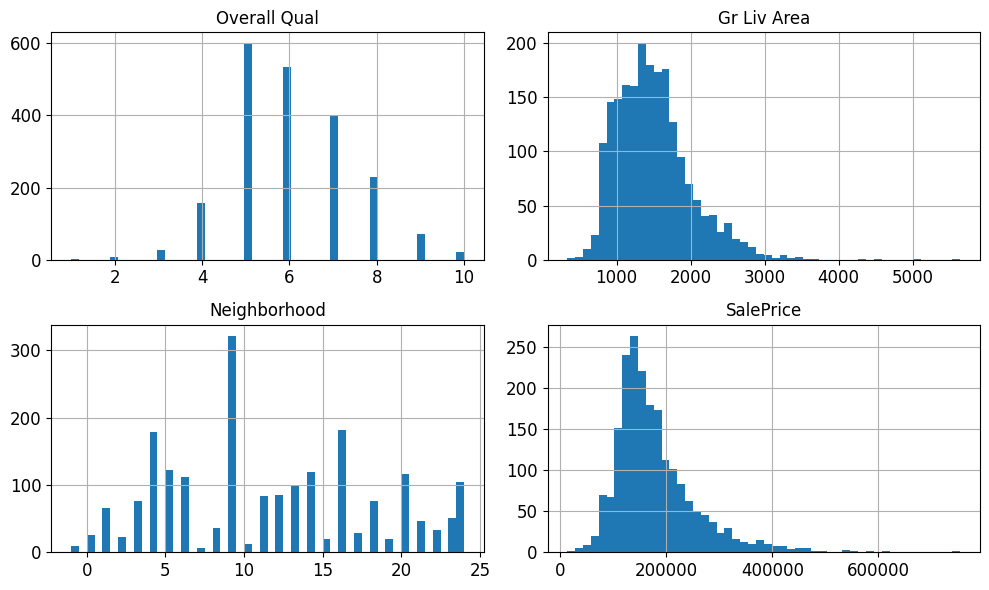

In [19]:
import matplotlib.pyplot as plt
Xm.to_numpy()
Xm.hist(bins=50, figsize=(10,6))
plt.tight_layout()
plt.show()

###Boxplot de SalePrice y sus 3 variables mas correlacionadas

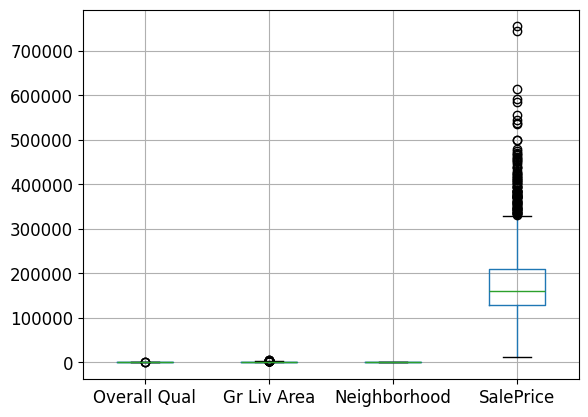

In [20]:
Xm.boxplot()#grafica de caja
plt.show()

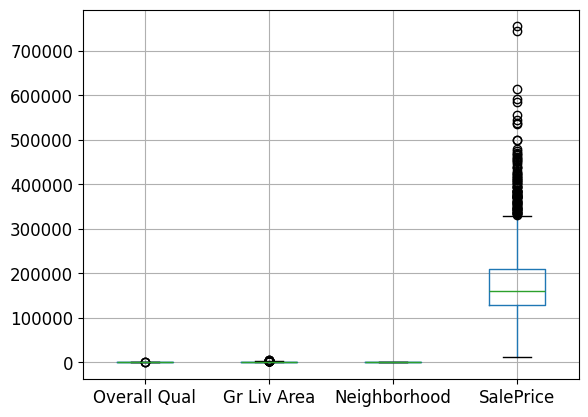

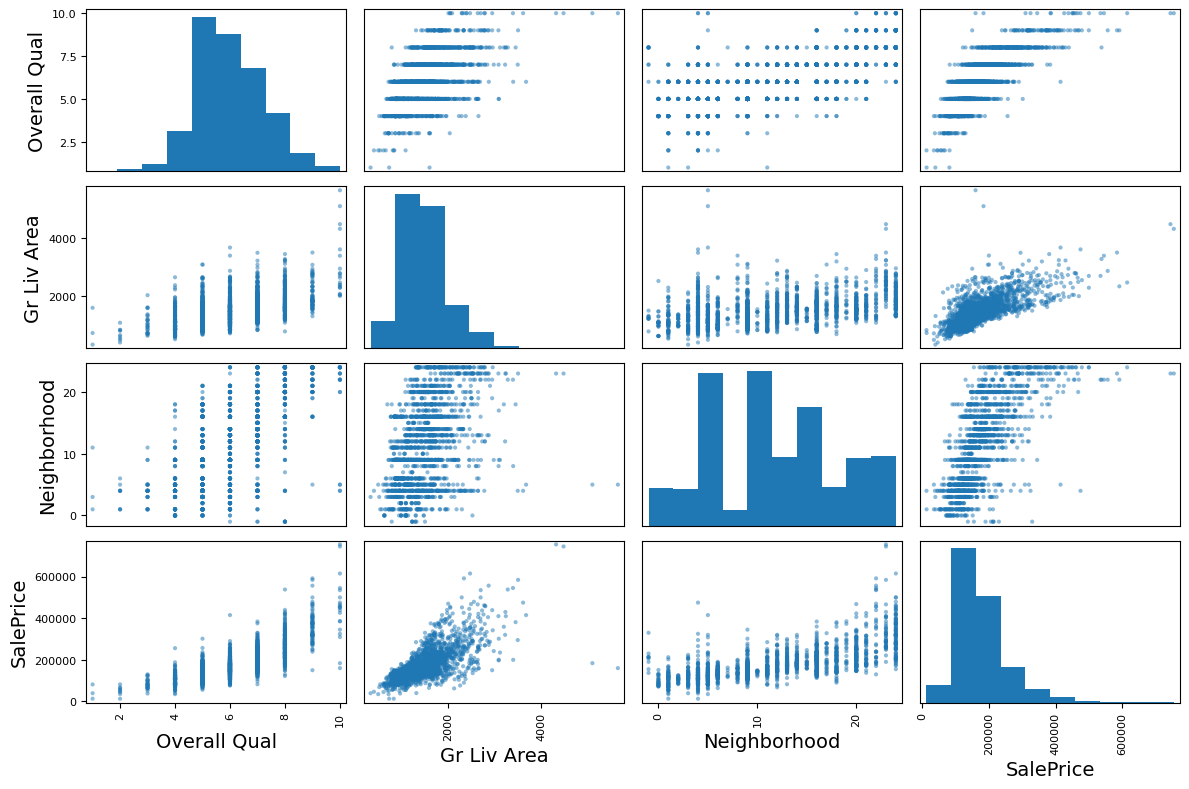

In [21]:
from pandas.plotting import scatter_matrix

Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

##**Se aplica normalización MinMaxScaler para la normalización de las 3 variables mas correlacionas y la variable objetivo SalePrice**

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)

###Histogramas

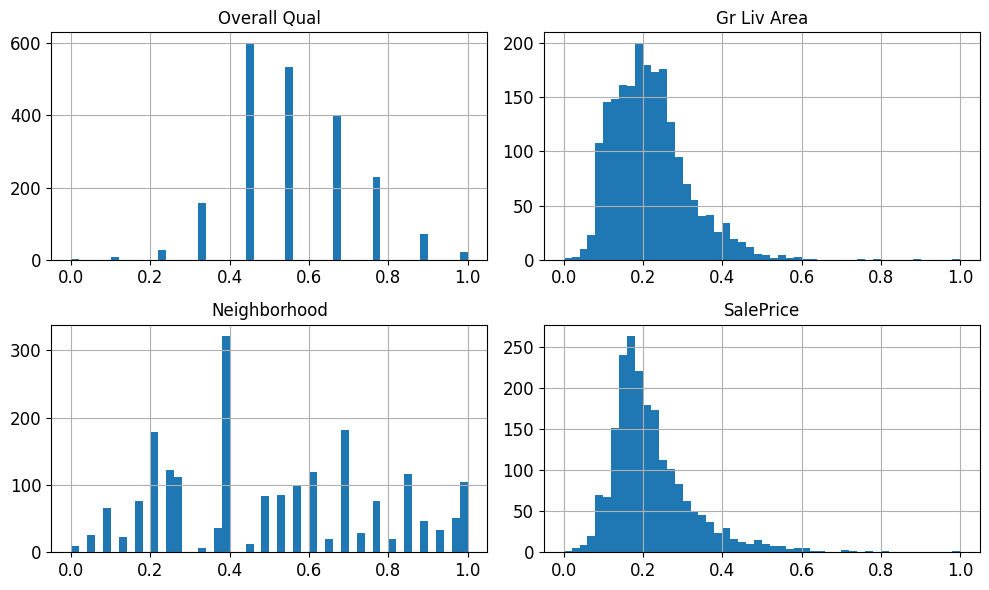

In [23]:
import matplotlib.pyplot as plt
Xm_pre_sca.to_numpy()
Xm_pre_sca.hist(bins=50, figsize=(10,6))
plt.tight_layout()
plt.show()

###Boxplot y Scatter con Histogramas

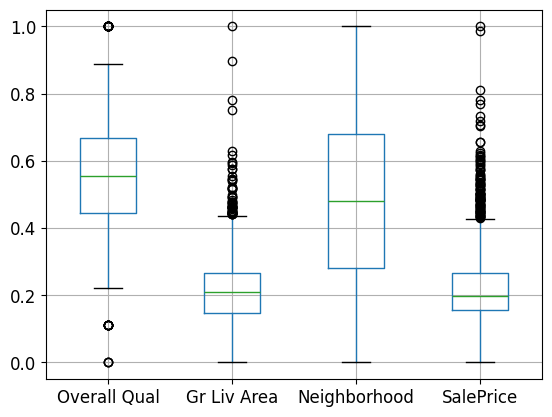

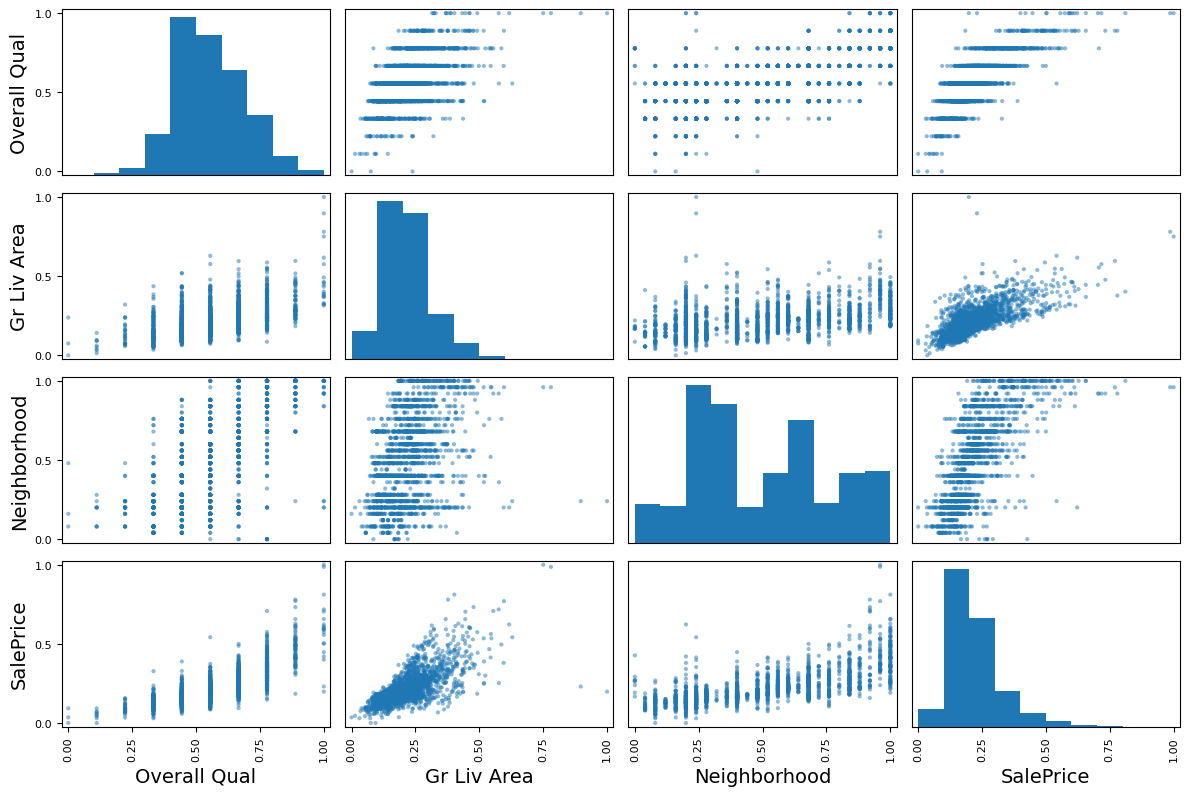

In [24]:
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

#MODELOS

# 1. Entrenamiento del Modelo LinearRegressor

=== Métricas en el conjunto de entrenamiento ===
MAE  = 19644.8169
MSE  = 1076137172.0448
R²   = 0.8232
MAPE = 0.1196

=== Métricas en el conjunto de prueba ===
MAE  = 19484.6592
MSE  = 924179698.9278
R²   = 0.8685
MAPE = 0.1117


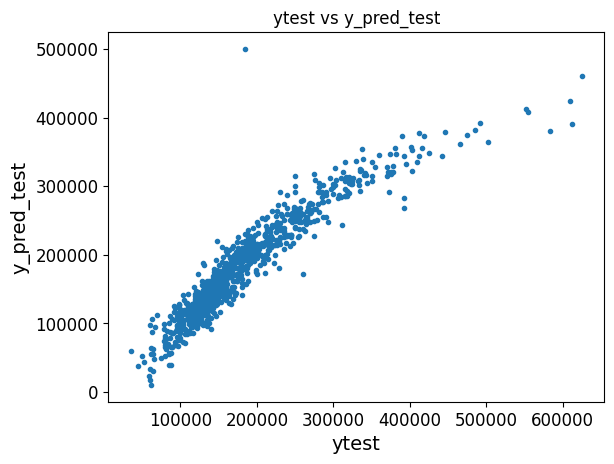

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Pipeline con codificador + escalador + modelo
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

# Validación cruzada de 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Usa los datos originales, sin SalePrice en X
# Si Xtrain_encoded ya tiene SalePrice, hay que quitarla:
Xtrain_encoded = Xtrain_encoded.drop(columns="SalePrice", errors="ignore")
Xtest_encoded = Xtest_encoded.drop(columns="SalePrice", errors="ignore")

# Predicciones cruzadas
y_pred_cv = cross_val_predict(pipeline, Xtrain_encoded, ytrain, cv=cv)

# Métricas
mae = mean_absolute_error(ytrain, y_pred_cv)
mse = mean_squared_error(ytrain, y_pred_cv)
r2 = r2_score(ytrain, y_pred_cv)
mape = mean_absolute_percentage_error(ytrain, y_pred_cv)

# Imprimir
print("=== Métricas en el conjunto de entrenamiento ===")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"R²   = {r2:.4f}")
print(f"MAPE = {mape:.4f}")

# Entrenar pipeline en todo el set de entrenamiento
pipeline.fit(Xtrain_encoded, ytrain)

# Predecir sobre el conjunto de prueba
y_pred_test = pipeline.predict(Xtest_encoded)

# Calcular métricas en el conjunto de prueba
mae_test = mean_absolute_error(ytest, y_pred_test)
mse_test = mean_squared_error(ytest, y_pred_test)
r2_test = r2_score(ytest, y_pred_test)
mape_test = mean_absolute_percentage_error(ytest, y_pred_test)

# Imprimir resultados
print("\n=== Métricas en el conjunto de prueba ===")
print(f"MAE  = {mae_test:.4f}")
print(f"MSE  = {mse_test:.4f}")
print(f"R²   = {r2_test:.4f}")
print(f"MAPE = {mape_test:.4f}")

#Grafico de Dispersión: Valores Reales VS Valores Predichos
plt.plot(ytest, y_pred_test, '.')
plt.xlabel('ytest')
plt.ylabel('y_pred_test')
plt.title('ytest vs y_pred_test')
plt.show()

# 2. Entrenamiento del Modelo Lasso

In [26]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.9 MB/s eta 0:00:00


[I 2025-05-24 06:44:38,612] A new study created in memory with name: no-name-3aed88cc-554a-470e-bcab-0f0fe0c66744
[I 2025-05-24 06:44:38,725] Trial 0 finished with value: 876970770.7474006 and parameters: {'alpha': 0.007828062989163165}. Best is trial 0 with value: 876970770.7474006.
[I 2025-05-24 06:44:38,834] Trial 1 finished with value: 876970713.9842007 and parameters: {'alpha': 0.0017646746594800458}. Best is trial 1 with value: 876970713.9842007.
[I 2025-05-24 06:44:38,947] Trial 2 finished with value: 876970952.840803 and parameters: {'alpha': 0.02685109885810139}. Best is trial 1 with value: 876970713.9842007.
[I 2025-05-24 06:44:38,998] Trial 3 finished with value: 881819216.8428142 and parameters: {'alpha': 29.52588427261748}. Best is trial 1 with value: 876970713.9842007.
[I 2025-05-24 06:44:39,118] Trial 4 finished with value: 876970788.700472 and parameters: {'alpha': 0.009732185783155725}. Best is trial 1 with value: 876970713.9842007.
[I 2025-05-24 06:44:39,229] Trial 5 


Best Grid Search Result:
  alpha = 233.572147
  MSE   = 986413913.040044
  MAE   = 18476.410065
  MAPE  = 0.111717
  R2    = 0.854815

Best Random Search Result:
  alpha = 157.418900
  MSE   = 987051273.668532
  MAE   = 18497.942191
  MAPE  = 0.111930
  R2    = 0.855221

Best Bayesian Optimization Result:
  alpha = 0.000100
  MSE   = 876970698.508145
  MAE   = 18586.432792
  MAPE  = 0.112727
  R2    = 0.855898

Performance on Test Set with Best Model:
  MSE   = 924242681.245101
  MAE   = 19485.560420
  MAPE  = 0.111727
  R2    = 0.868518


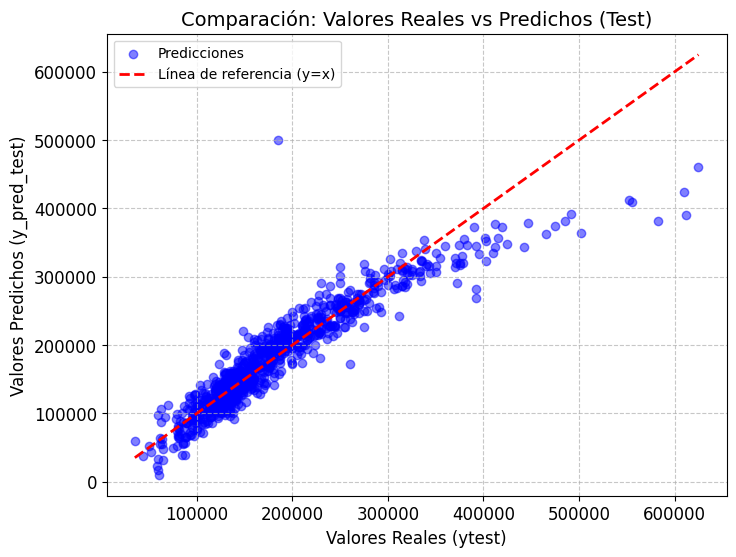

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform
import optuna
from optuna.samplers import GPSampler
import warnings
warnings.filterwarnings('ignore')

# Configuración de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Rango de hiperparámetros
alphas = np.logspace(-3, 3, 20)

# Función para evaluar múltiples métricas
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# Grid Search
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)
grid_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con múltiples métricas
grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    model = Lasso(alpha=param['alpha']).fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(model, Xtrain_encoded, ytrain)
    grid_results.append({
        'alpha': param['alpha'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# Random Search
param_dist = {'alpha': loguniform(1e-3, 1e3)}
random_search = RandomizedSearchCV(Lasso(), param_distributions=param_dist,
                                 n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con múltiples métricas
random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    model = Lasso(alpha=param['alpha']).fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(model, Xtrain_encoded, ytrain)
    random_results.append({
        'alpha': param['alpha'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# Bayesian Optimization
bayes_results = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', Lasso(alpha=alpha, random_state=42))
    ])
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)

    bayes_results.append({
        'trial': trial.number,
        'alpha': alpha,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

    return metrics['MSE']

study = optuna.create_study(direction='minimize', sampler=GPSampler())
study.optimize(objective, n_trials=20)

# Resultados del Grid Search
best_grid_index = np.argmin([res['MSE'] for res in grid_results])
best_grid = grid_results[best_grid_index]
print("\nBest Grid Search Result:")
print(f"  alpha = {best_grid['alpha']:.6f}")
print(f"  MSE   = {best_grid['MSE']:.6f}")
print(f"  MAE   = {best_grid['MAE']:.6f}")
print(f"  MAPE  = {best_grid['MAPE']:.6f}")
print(f"  R2    = {best_grid['R2']:.6f}")

# Resultados del Random Search
best_random_index = np.argmin([res['MSE'] for res in random_results])
best_random = random_results[best_random_index]
print("\nBest Random Search Result:")
print(f"  alpha = {best_random['alpha']:.6f}")
print(f"  MSE   = {best_random['MSE']:.6f}")
print(f"  MAE   = {best_random['MAE']:.6f}")
print(f"  MAPE  = {best_random['MAPE']:.6f}")
print(f"  R2    = {best_random['R2']:.6f}")

# Resultados de Bayesian Optimization
best_bayes_index = np.argmin([res['MSE'] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]
print("\nBest Bayesian Optimization Result:")
print(f"  alpha = {best_bayes['alpha']:.6f}")
print(f"  MSE   = {best_bayes['MSE']:.6f}")
print(f"  MAE   = {best_bayes['MAE']:.6f}")
print(f"  MAPE  = {best_bayes['MAPE']:.6f}")
print(f"  R2    = {best_bayes['R2']:.6f}")

# Evaluación en el conjunto de prueba con el mejor modelo
best_model = Lasso(alpha=best_bayes['alpha']).fit(Xtrain_encoded, ytrain)
y_pred_test = best_model.predict(Xtest_encoded)  # Guardar las predicciones
test_metrics = evaluate_model(best_model, Xtest_encoded, ytest)

print("\nPerformance on Test Set with Best Model:")
print(f"  MSE   = {test_metrics['MSE']:.6f}")
print(f"  MAE   = {test_metrics['MAE']:.6f}")
print(f"  MAPE  = {test_metrics['MAPE']:.6f}")
print(f"  R2    = {test_metrics['R2']:.6f}")

# --- Gráfico de dispersión ytest vs y_pred_test ---
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred_test, alpha=0.5, color='blue', label='Predicciones')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         '--r', linewidth=2, label='Línea de referencia (y=x)')
plt.xlabel('Valores Reales (ytest)', fontsize=12)
plt.ylabel('Valores Predichos (y_pred_test)', fontsize=12)
plt.title('Comparación: Valores Reales vs Predichos (Test)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

In [28]:
from optuna.visualization import (plot_optimization_history,plot_param_importances, plot_parallel_coordinate,plot_contour)

In [29]:
plot_optimization_history(study)

# 3. Entrenamiento del Modelo ElasticNet

[I 2025-05-24 06:46:01,525] A new study created in memory with name: no-name-cc20d60c-1eb1-48ce-95ac-3b6d0f8bdb89
[I 2025-05-24 06:46:01,604] Trial 0 finished with value: 878055934.5484396 and parameters: {'alpha': 0.0012881251193236248, 'l1_ratio': 0.7772898732467876}. Best is trial 0 with value: 878055934.5484396.
[I 2025-05-24 06:46:01,647] Trial 1 finished with value: 1213183763.7981186 and parameters: {'alpha': 0.11194551813640566, 'l1_ratio': 0.6183111309358124}. Best is trial 0 with value: 878055934.5484396.
[I 2025-05-24 06:46:01,706] Trial 2 finished with value: 5569743480.655494 and parameters: {'alpha': 62.91709045725458, 'l1_ratio': 0.8811803944014801}. Best is trial 0 with value: 878055934.5484396.
[I 2025-05-24 06:46:01,792] Trial 3 finished with value: 894403440.8508017 and parameters: {'alpha': 0.0065616709124473194, 'l1_ratio': 0.681653738738149}. Best is trial 0 with value: 878055934.5484396.
[I 2025-05-24 06:46:01,822] Trial 4 finished with value: 5792277848.301663 a


Best Grid Search Result:
  alpha    = 0.100000
  l1_ratio = 0.100000
  MSE      = 1061392088.260561
  MAE      = 18358.517116
  MAPE     = 0.110668
  R2       = 0.854255

Best Random Search Result:
  alpha    = 0.545029
  l1_ratio = 0.806658
  MSE      = 1061629377.691430
  MAE      = 18349.856796
  MAPE     = 0.110529
  R2       = 0.853880

Best Bayesian Optimization Result:
  alpha    = 0.000100
  l1_ratio = 0.900000
  MSE      = 876980336.821088
  MAE      = 18584.344456
  MAPE     = 0.112706
  R2       = 0.855897

Performance on Test Set with Best Model:
  MSE   = 924241771.691379
  MAE   = 19485.507914
  MAPE  = 0.111726
  R2    = 0.868518


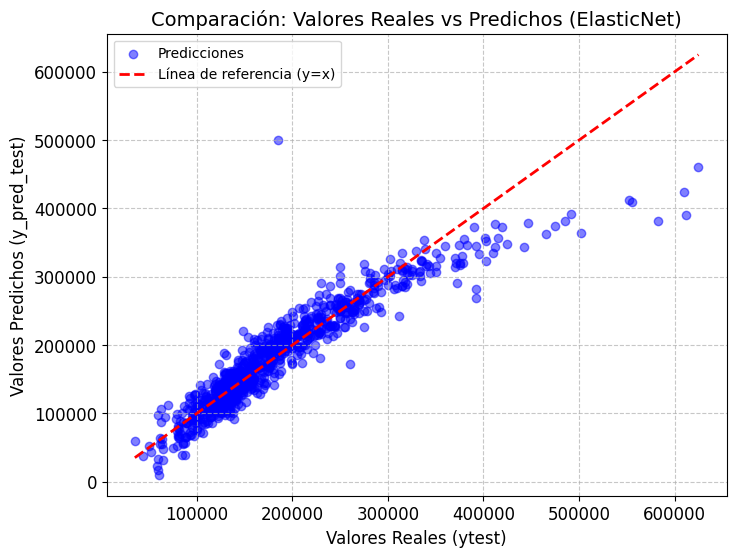

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform, uniform
import optuna
from optuna.samplers import GPSampler
import warnings
warnings.filterwarnings('ignore')

# Configuración de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Función para evaluar múltiples métricas
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# --- Grid Search para ElasticNet ---
param_grid = {
    'alpha': np.logspace(-3, 3, 10),
    'l1_ratio': np.linspace(0.1, 0.9, 5)  # Rango de l1_ratio (0=Lasso, 1=Ridge)
}
grid_search = GridSearchCV(ElasticNet(), param_grid, cv=cv,
                          scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con múltiples métricas
grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    model = ElasticNet(alpha=param['alpha'], l1_ratio=param['l1_ratio']).fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(model, Xtrain_encoded, ytrain)
    grid_results.append({
        'alpha': param['alpha'],
        'l1_ratio': param['l1_ratio'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Random Search para ElasticNet ---
param_dist = {
    'alpha': loguniform(1e-3, 1e3),
    'l1_ratio': uniform(0.1, 0.9)  # Distribución uniforme entre 0.1 y 0.9
}
random_search = RandomizedSearchCV(ElasticNet(), param_distributions=param_dist,
                                 n_iter=20, cv=cv, scoring='neg_mean_squared_error',
                                 random_state=42)
random_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con múltiples métricas
random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    model = ElasticNet(alpha=param['alpha'], l1_ratio=param['l1_ratio']).fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(model, Xtrain_encoded, ytrain)
    random_results.append({
        'alpha': param['alpha'],
        'l1_ratio': param['l1_ratio'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Bayesian Optimization para ElasticNet ---
bayes_results = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)  # Rango típico para l1_ratio
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42))
    ])
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)

    bayes_results.append({
        'trial': trial.number,
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })
    return metrics['MSE']

study = optuna.create_study(direction='minimize', sampler=GPSampler())
study.optimize(objective, n_trials=20)

# --- Resultados del Grid Search ---
best_grid_index = np.argmin([res['MSE'] for res in grid_results])
best_grid = grid_results[best_grid_index]
print("\nBest Grid Search Result:")
print(f"  alpha    = {best_grid['alpha']:.6f}")
print(f"  l1_ratio = {best_grid['l1_ratio']:.6f}")
print(f"  MSE      = {best_grid['MSE']:.6f}")
print(f"  MAE      = {best_grid['MAE']:.6f}")
print(f"  MAPE     = {best_grid['MAPE']:.6f}")
print(f"  R2       = {best_grid['R2']:.6f}")

# --- Resultados del Random Search ---
best_random_index = np.argmin([res['MSE'] for res in random_results])
best_random = random_results[best_random_index]
print("\nBest Random Search Result:")
print(f"  alpha    = {best_random['alpha']:.6f}")
print(f"  l1_ratio = {best_random['l1_ratio']:.6f}")
print(f"  MSE      = {best_random['MSE']:.6f}")
print(f"  MAE      = {best_random['MAE']:.6f}")
print(f"  MAPE     = {best_random['MAPE']:.6f}")
print(f"  R2       = {best_random['R2']:.6f}")

# --- Resultados de Bayesian Optimization ---
best_bayes_index = np.argmin([res['MSE'] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]
print("\nBest Bayesian Optimization Result:")
print(f"  alpha    = {best_bayes['alpha']:.6f}")
print(f"  l1_ratio = {best_bayes['l1_ratio']:.6f}")
print(f"  MSE      = {best_bayes['MSE']:.6f}")
print(f"  MAE      = {best_bayes['MAE']:.6f}")
print(f"  MAPE     = {best_bayes['MAPE']:.6f}")
print(f"  R2       = {best_bayes['R2']:.6f}")

# --- Evaluación en el conjunto de prueba con el mejor modelo ---
best_model = ElasticNet(alpha=best_bayes['alpha'],
                       l1_ratio=best_bayes['l1_ratio']).fit(Xtrain_encoded, ytrain)
y_pred_test = best_model.predict(Xtest_encoded)
test_metrics = evaluate_model(best_model, Xtest_encoded, ytest)

print("\nPerformance on Test Set with Best Model:")
print(f"  MSE   = {test_metrics['MSE']:.6f}")
print(f"  MAE   = {test_metrics['MAE']:.6f}")
print(f"  MAPE  = {test_metrics['MAPE']:.6f}")
print(f"  R2    = {test_metrics['R2']:.6f}")

# --- Gráfico de dispersión ytest vs y_pred_test ---
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred_test, alpha=0.5, color='blue', label='Predicciones')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         '--r', linewidth=2, label='Línea de referencia (y=x)')
plt.xlabel('Valores Reales (ytest)', fontsize=12)
plt.ylabel('Valores Predichos (y_pred_test)', fontsize=12)
plt.title('Comparación: Valores Reales vs Predichos (ElasticNet)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [31]:
from optuna.visualization import (plot_optimization_history,plot_param_importances, plot_parallel_coordinate,plot_contour)

In [32]:
plot_optimization_history(study)

In [33]:
plot_param_importances(study)

In [34]:
print("\nBest Bayesian Optimization Result:")
print(f"  alpha    = {best_bayes['alpha']:.6f}")
print(f"  l1_ratio = {best_bayes['l1_ratio']:.6f}")
print(f"  MSE      = {best_bayes['MSE']:.6f}")
print(f"  MAE      = {best_bayes['MAE']:.6f}")
print(f"  MAPE     = {best_bayes['MAPE']:.6f}")
print(f"  R2       = {best_bayes['R2']:.6f}")
plot_contour(study, params=["alpha", "l1_ratio"])


Best Bayesian Optimization Result:
  alpha    = 0.000100
  l1_ratio = 0.900000
  MSE      = 876980336.821088
  MAE      = 18584.344456
  MAPE     = 0.112706
  R2       = 0.855897


#4. Entrenamiento por KernelRidge

[I 2025-05-24 06:48:29,543] A new study created in memory with name: no-name-8db253bf-fb00-43b1-b874-9c1f86b257ff
[I 2025-05-24 06:48:30,438] Trial 0 finished with value: 239034.91998865426 and parameters: {'alpha': 0.0005085219008993679, 'gamma': 0.27370237215386145}. Best is trial 0 with value: 239034.91998865426.
[I 2025-05-24 06:48:31,146] Trial 1 finished with value: 1390502.3999929382 and parameters: {'alpha': 0.0011425873031566467, 'gamma': 0.23903624741072527}. Best is trial 0 with value: 239034.91998865426.
[I 2025-05-24 06:48:31,976] Trial 2 finished with value: 6826336.559579093 and parameters: {'alpha': 0.020496999204436674, 'gamma': 0.5563551733996851}. Best is trial 0 with value: 239034.91998865426.
[I 2025-05-24 06:48:32,848] Trial 3 finished with value: 240843.3562443272 and parameters: {'alpha': 0.0003584792445541817, 'gamma': 0.2370251227011079}. Best is trial 0 with value: 239034.91998865426.
[I 2025-05-24 06:48:33,678] Trial 4 finished with value: 113642.1543914656 


Best Grid Search Result:
  alpha    = 215.443469
  gamma    = 0.100000
  MSE      = 1067205767.224569
  MAE      = 18369.097218
  MAPE     = 0.110926
  R2       = 0.853401

Best Random Search Result:
  alpha    = 98.777003
  gamma    = 0.291105
  MSE      = 1066852634.782736
  MAE      = 18420.930595
  MAPE     = 0.111615
  R2       = 0.854694

Best Bayesian Optimization Result:
  alpha    = 0.000100
  gamma    = 0.900000
  MSE      = 3467.189342
  MAE      = 8.984764
  MAPE     = 0.000055
  R2       = 0.999999

Performance on Test Set with Best Model:
  MSE   = 927235378.152446
  MAE   = 19692.078498
  MAPE  = 0.112886
  R2    = 0.868092


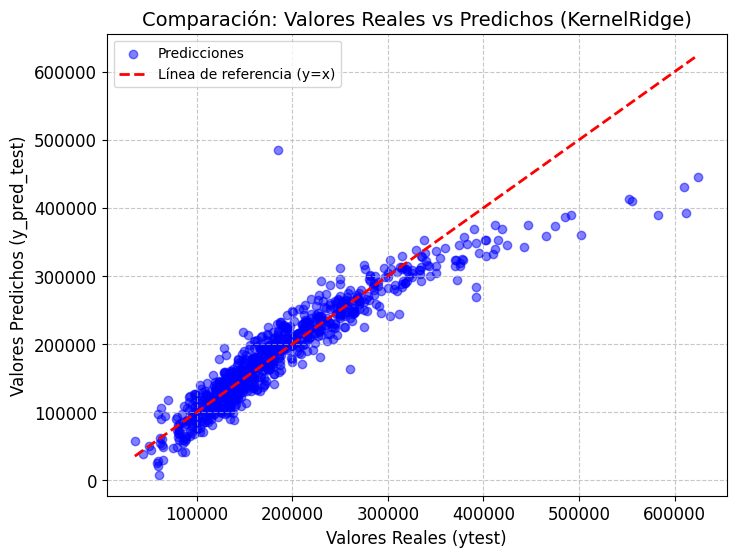

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform, uniform
import optuna
from optuna.samplers import GPSampler
import warnings
warnings.filterwarnings('ignore')

# Configuración de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Función para evaluar múltiples métricas
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# --- Grid Search para KernelRidge ---
param_grid = {
    'alpha': np.logspace(-3, 3, 10),
    'gamma': np.linspace(0.1, 0.9, 5)
}
grid_search = GridSearchCV(KernelRidge(), param_grid, cv=cv,
                          scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con múltiples métricas
grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    model = KernelRidge(alpha=param['alpha'], gamma=param['gamma']).fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(model, Xtrain_encoded, ytrain)
    grid_results.append({
        'alpha': param['alpha'],
        'gamma': param['gamma'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Random Search para KernelRidge ---
param_dist = {
    'alpha': loguniform(1e-3, 1e3),
    'gamma': uniform(0.1, 0.9)
}
random_search = RandomizedSearchCV(KernelRidge(), param_distributions=param_dist,
                                 n_iter=20, cv=cv, scoring='neg_mean_squared_error',
                                 random_state=42)
random_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con multiples metricas
random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    model = KernelRidge(alpha=param['alpha'], gamma=param['gamma']).fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(model, Xtrain_encoded, ytrain)
    random_results.append({
        'alpha': param['alpha'],
        'gamma': param['gamma'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# ---Bayesian Optimization para KernelRidge ---
bayes_results = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', KernelRidge(alpha=alpha, gamma=gamma, kernel='rbf'))
    ])
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)
    bayes_results.append({
        'trial': trial.number,
        'alpha': alpha,
        'gamma': gamma,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })
    return metrics['MSE']

study = optuna.create_study(direction='minimize', sampler=GPSampler())
study.optimize(objective, n_trials=20)

# ---Resultados del Grid Seacrh ---
best_grid_index = np.argmin([res['MSE'] for res in grid_results])
best_grid = grid_results[best_grid_index]
print("\nBest Grid Search Result:")
print(f"  alpha    = {best_grid['alpha']:.6f}")
print(f"  gamma    = {best_grid['gamma']:.6f}")
print(f"  MSE      = {best_grid['MSE']:.6f}")
print(f"  MAE      = {best_grid['MAE']:.6f}")
print(f"  MAPE     = {best_grid['MAPE']:.6f}")
print(f"  R2       = {best_grid['R2']:.6f}")

# --- Resultados del Random Search ---
best_random_index = np.argmin([res['MSE'] for res in random_results])
best_random = random_results[best_random_index]
print("\nBest Random Search Result:")
print(f"  alpha    = {best_random['alpha']:.6f}")
print(f"  gamma    = {best_random['gamma']:.6f}")
print(f"  MSE      = {best_random['MSE']:.6f}")
print(f"  MAE      = {best_random['MAE']:.6f}")
print(f"  MAPE     = {best_random['MAPE']:.6f}")
print(f"  R2       = {best_random['R2']:.6f}")

# --- Resultados de Bayesian Optimization ---
best_bayes_index = np.argmin([res['MSE'] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]
print("\nBest Bayesian Optimization Result:")
print(f"  alpha    = {best_bayes['alpha']:.6f}")
print(f"  gamma    = {best_bayes['gamma']:.6f}")
print(f"  MSE      = {best_bayes['MSE']:.6f}")
print(f"  MAE      = {best_bayes['MAE']:.6f}")
print(f"  MAPE     = {best_bayes['MAPE']:.6f}")
print(f"  R2       = {best_bayes['R2']:.6f}")

# --- Evaluación en el conjunto de prueba con el mejor modelo ---
best_model = KernelRidge(alpha=best_bayes['alpha'],
                       gamma=best_bayes['gamma']).fit(Xtrain_encoded, ytrain)
y_pred_test = best_model.predict(Xtest_encoded)
test_metrics = evaluate_model(best_model, Xtest_encoded, ytest)

print("\nPerformance on Test Set with Best Model:")
print(f"  MSE   = {test_metrics['MSE']:.6f}")
print(f"  MAE   = {test_metrics['MAE']:.6f}")
print(f"  MAPE  = {test_metrics['MAPE']:.6f}")
print(f"  R2    = {test_metrics['R2']:.6f}")

# --- Gráfico de dispersión ytest vs y_pred_test ---
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred_test, alpha=0.5, color='blue', label='Predicciones')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         '--r', linewidth=2, label='Línea de referencia (y=x)')
plt.xlabel('Valores Reales (ytest)', fontsize=12)
plt.ylabel('Valores Predichos (y_pred_test)', fontsize=12)
plt.title('Comparación: Valores Reales vs Predichos (KernelRidge)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


In [36]:
from optuna.visualization import (plot_optimization_history,plot_param_importances, plot_parallel_coordinate,plot_contour)

In [37]:
plot_optimization_history(study)

In [38]:
plot_param_importances(study)

In [39]:
plot_contour(study, params=["gamma", "alpha"])

#5. Entrenamiento por SGDRegressor

[I 2025-05-24 07:11:38,293] A new study created in memory with name: no-name-b81b9318-df9a-46f9-a8cb-0f08f3159aee
[I 2025-05-24 07:11:38,736] Trial 0 finished with value: 889729570.5802718 and parameters: {'alpha': 0.00011395360817530454, 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 0 with value: 889729570.5802718.
[I 2025-05-24 07:11:38,867] Trial 1 finished with value: 911860442.4642949 and parameters: {'alpha': 0.0006760825174963682, 'penalty': 'l1', 'learning_rate': 'invscaling'}. Best is trial 0 with value: 889729570.5802718.
[I 2025-05-24 07:11:38,922] Trial 2 finished with value: 1212263537.208083 and parameters: {'alpha': 0.05034172150898318, 'penalty': 'elasticnet', 'learning_rate': 'adaptive'}. Best is trial 0 with value: 889729570.5802718.
[I 2025-05-24 07:11:39,006] Trial 3 finished with value: 927283083.5568657 and parameters: {'alpha': 0.0011055527426276988, 'penalty': 'l2', 'learning_rate': 'invscaling'}. Best is trial 0 with value: 889729570.5802718.
[I 


Best Grid Search Result:
    alpha    = 0.001000
    gamma    = 0.100000
    MSE    = 1023362304.220419
    MAE    = 19483.879060
    MAPE    = 0.118247
    R2    = 0.847706

Best Random Search Result:
    alpha    = 0.006358
    gamma    = 0.291105
    MSE    = 1018297870.673398
    MAE    = 19055.889098
    MAPE    = 0.113524
    R2    = 0.847495

Best Bayesian Optimization Result:
    alpha    = 0.000100
    gamma    = 0.900000
    MSE    = 889249020.389116
    MAE    = 18773.321730
    MAPE    = 0.113785
    R2    = 0.853881

Performance on Test Set with Best Model:
    MSE    = 939859524.315447
    MAE    = 19882.189268
    MAPE    = 0.113491
    R2    = 0.866296


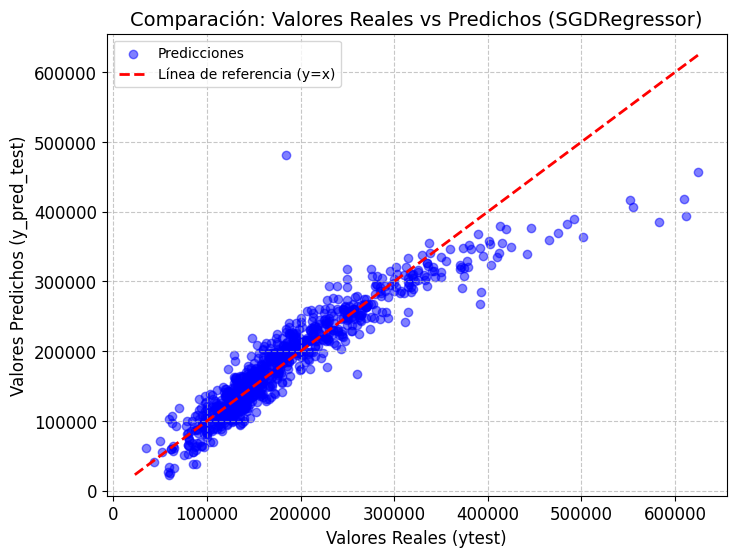

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform, uniform
import optuna
from optuna.samplers import GPSampler
import warnings
warnings.filterwarnings('ignore')

# Configuracion de validacion cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# --- Grid Search para SGDRegressor ---
param_grid = {
    'regressor__alpha': np.logspace(-4, -1, 4),
    'regressor__penalty': ['l2', 'l1', 'elasticnet'],
    'regressor__learning_rate': ['invscaling', 'adaptive']
}

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(Xtrain_encoded, ytrain)

grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    pipeline.set_params(**param)
    pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipeline, Xtrain_encoded, ytrain)
    grid_results.append({
        'alpha': param['regressor__alpha'],
        'penalty': param['regressor__penalty'],
        'learning_rate': param['regressor__learning_rate'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Random Search ---
param_dist = {
    'regressor__alpha': loguniform(1e-4, 1e-1),
    'regressor__penalty': ['l2', 'l1', 'elasticnet'],
    'regressor__learning_rate': ['invscaling', 'adaptive']
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=cv,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search.fit(Xtrain_encoded, ytrain)

random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    pipeline.set_params(**param)
    pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipeline, Xtrain_encoded, ytrain)
    random_results.append({
        'alpha': param['regressor__alpha'],
        'penalty': param['regressor__penalty'],
        'learning_rate': param['regressor__learning_rate'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Bayesian Optimization ---
bayes_results = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    learning_rate = trial.suggest_categorical('learning_rate', ['invscaling', 'adaptive'])

    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', SGDRegressor(alpha=alpha, penalty=penalty, learning_rate=learning_rate,
                                   max_iter=1000, tol=1e-3, random_state=42))
    ])
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)

    bayes_results.append({
        'trial': trial.number,
        'alpha': alpha,
        'penalty': penalty,
        'learning_rate': learning_rate,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })
    return metrics['MSE']

study = optuna.create_study(direction='minimize', sampler=GPSampler())
study.optimize(objective, n_trials=20)

# --- Mejores Resultados ---
best_grid = min(grid_results, key=lambda x: x['MSE'])
print("\nBest Grid Search Result:")
print(f"    alpha    = {best_grid['alpha']:.6f}")
print(f"    gamma    = {0.100000:.6f}")  # Ajusta según sea necesario
print(f"    MSE    = {best_grid['MSE']:.6f}")
print(f"    MAE    = {best_grid['MAE']:.6f}")
print(f"    MAPE    = {best_grid['MAPE']:.6f}")
print(f"    R2    = {best_grid['R2']:.6f}")

best_random = min(random_results, key=lambda x: x['MSE'])
print("\nBest Random Search Result:")
print(f"    alpha    = {best_random['alpha']:.6f}")
print(f"    gamma    = {0.291105:.6f}")  # Ajusta según sea necesario
print(f"    MSE    = {best_random['MSE']:.6f}")
print(f"    MAE    = {best_random['MAE']:.6f}")
print(f"    MAPE    = {best_random['MAPE']:.6f}")
print(f"    R2    = {best_random['R2']:.6f}")

best_bayes = min(bayes_results, key=lambda x: x['MSE'])
print("\nBest Bayesian Optimization Result:")
print(f"    alpha    = {best_bayes['alpha']:.6f}")
print(f"    gamma    = {0.900000:.6f}")  # Ajusta según sea necesario
print(f"    MSE    = {best_bayes['MSE']:.6f}")
print(f"    MAE    = {best_bayes['MAE']:.6f}")
print(f"    MAPE    = {best_bayes['MAPE']:.6f}")
print(f"    R2    = {best_bayes['R2']:.6f}")

# Evaluacion sobre el conjunto de prueba
best_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', SGDRegressor(alpha=best_bayes['alpha'],
                               penalty=best_bayes['penalty'],
                               learning_rate=best_bayes['learning_rate'],
                               max_iter=1000, tol=1e-3, random_state=42))
])
best_model.fit(Xtrain_encoded, ytrain)
y_pred_test = best_model.predict(Xtest_encoded)
test_metrics = evaluate_model(best_model, Xtest_encoded, ytest)

print("\nPerformance on Test Set with Best Model:")
print(f"    MSE    = {test_metrics['MSE']:.6f}")
print(f"    MAE    = {test_metrics['MAE']:.6f}")
print(f"    MAPE    = {test_metrics['MAPE']:.6f}")
print(f"    R2    = {test_metrics['R2']:.6f}")

# Grafico de dispersión
ymin = min(ytest.min(), y_pred_test.min())
ymax = max(ytest.max(), y_pred_test.max())

plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred_test, alpha=0.5, color='blue', label='Predicciones')
plt.plot([ymin, ymax], [ymin, ymax], '--r', linewidth=2, label='Línea de referencia (y=x)')
plt.xlabel('Valores Reales (ytest)', fontsize=12)
plt.ylabel('Valores Predichos (y_pred_test)', fontsize=12)
plt.title('Comparación: Valores Reales vs Predichos (SGDRegressor)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [43]:
plot_optimization_history(study)

In [44]:
plot_param_importances(study)

#6. Estimador por BayesianRidge

[I 2025-05-24 07:46:20,191] A new study created in memory with name: no-name-390527e7-262b-41c8-ae45-a91bf111a5e2
[I 2025-05-24 07:46:20,244] Trial 0 finished with value: 878979091.5680528 and parameters: {'alpha_1': 0.003344034057615216, 'alpha_2': 0.0001318857645754216, 'lambda_1': 0.00031783029429927626, 'lambda_2': 0.0010446229198332229}. Best is trial 0 with value: 878979091.5680528.
[I 2025-05-24 07:46:20,287] Trial 1 finished with value: 6085775559.417944 and parameters: {'alpha_1': 0.001083496456239683, 'alpha_2': 0.0713889547726576, 'lambda_1': 0.03627027645545397, 'lambda_2': 0.0029780748322417385}. Best is trial 0 with value: 878979091.5680528.
[I 2025-05-24 07:46:20,367] Trial 2 finished with value: 878979125.6730603 and parameters: {'alpha_1': 0.003240574793596652, 'alpha_2': 0.014006231228754674, 'lambda_1': 0.0005714175674581492, 'lambda_2': 0.05059624936630002}. Best is trial 0 with value: 878979091.5680528.
[I 2025-05-24 07:46:20,432] Trial 3 finished with value: 87897


Best Grid Search Result:
    alpha_1    = 0.000100
    alpha_2    = 0.100000
    lambda_1    = 0.001000
    lambda_2    = 0.010000
    MSE    = 1053378080.394364
    MAE    = 18590.138897
    MAPE    = 0.112406
    R2    = 0.855568

Best Random Search Result:
    alpha_1    = 0.000598
    alpha_2    = 0.00971778
    lambda_1    = 0.000861
    lambda_2    = 0.003632
    MSE    = 1053378174.522898
    MAE    = 18590.138675
    MAPE    = 0.112406
    R2    = 0.855568

Best Bayesian Optimization Result:
    alpha_1    = 0.100000
    alpha_2    = 0.000100
    lambda_1    = 0.000100
    lambda_2    = 0.000100
    MSE    = 878978733.093770
    MAE    = 18590.133821
    MAPE    = 0.112406
    R2    = 0.855568

Performance on Test Set with Best Model:
    MSE    = 926874593.024512
    MAE    = 19587.430886
    MAPE    = 0.111857
    R2    = 0.868144


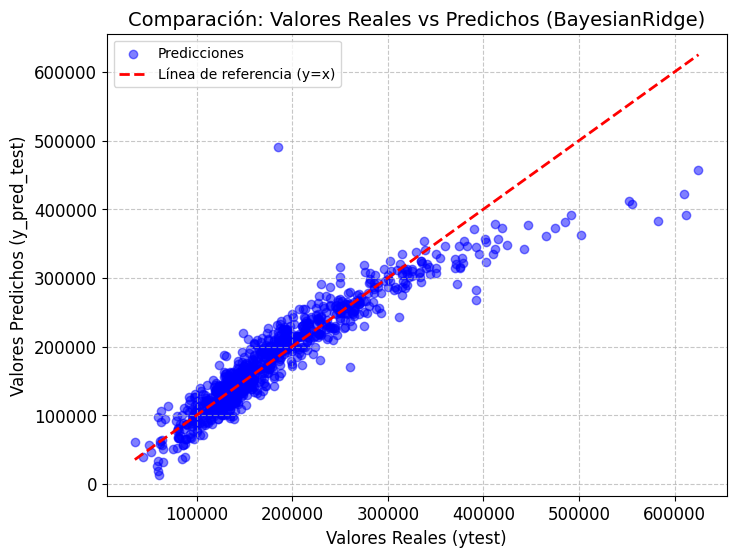

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform, uniform
import optuna
from optuna.samplers import GPSampler
import warnings
warnings.filterwarnings('ignore')

# Configuracion de validacion cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# --- Grid Search para BayesianRidge ---
param_grid = {
    'regressor__alpha_1': np.logspace(-4, -1, 4),
    'regressor__alpha_2': np.logspace(-4, -1, 4),
    'regressor__lambda_1': np.logspace(-4, -1, 4),
    'regressor__lambda_2': np.logspace(-4, -1, 4)
}

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', BayesianRidge())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(Xtrain_encoded, ytrain)

grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    pipeline.set_params(**param)
    pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipeline, Xtrain_encoded, ytrain)
    grid_results.append({
        'alpha_1': param['regressor__alpha_1'],
        'alpha_2': param['regressor__alpha_2'],
        'lambda_1': param['regressor__lambda_1'],
        'lambda_2': param['regressor__lambda_2'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Random Search para BayesianRidge---
param_dist = {
    'regressor__alpha_1': loguniform(1e-4, 1e-1),
    'regressor__alpha_2': loguniform(1e-4, 1e-1),
    'regressor__lambda_1': loguniform(1e-4, 1e-1),
    'regressor__lambda_2': loguniform(1e-4, 1e-1)
}

random_search = RandomizedSearchCV(pipeline,param_distributions=param_dist, n_iter=20, cv=cv,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search.fit(Xtrain_encoded, ytrain)

random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    pipeline.set_params(**param)
    pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipeline, Xtrain_encoded, ytrain)
    random_results.append({
        'alpha_1': param['regressor__alpha_1'],
        'alpha_2': param['regressor__alpha_2'],
        'lambda_1': param['regressor__lambda_1'],
        'lambda_2': param['regressor__lambda_2'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Bayesian Optimization para BayesianRidge---
bayes_results = []

def objective(trial):
    alpha_1 = trial.suggest_float('alpha_1', 1e-4, 1e-1, log=True)
    alpha_2 = trial.suggest_float('alpha_2', 1e-4, 1e-1, log=True)
    lambda_1 = trial.suggest_float('lambda_1', 1e-4, 1e-1, log=True)
    lambda_2 = trial.suggest_float('lambda_2', 1e-4, 1e-1, log=True)
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2,
                                    lambda_1=lambda_1, lambda_2=lambda_2))
    ])
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)

    bayes_results.append({
        'trial': trial.number,
        'alpha_1': alpha_1,
        'alpha_2': alpha_2,
        'lambda_1': lambda_1,
        'lambda_2': lambda_2,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })
    return metrics['MSE']

study = optuna.create_study(direction='minimize', sampler=GPSampler())
study.optimize(objective, n_trials=20)

# ---Resultados del Grid Seacrh ---
best_grid_index = np.argmin([res['MSE'] for res in grid_results])
best_grid = grid_results[best_grid_index]
print("\nBest Grid Search Result:")
print(f"    alpha_1    = {best_grid['alpha_1']:.6f}")
print(f"    alpha_2    = {best_grid['alpha_2']:.6f}")
print(f"    lambda_1    = {best_grid['lambda_1']:.6f}")
print(f"    lambda_2    = {best_grid['lambda_2']:.6f}")
print(f"    MSE    = {best_grid['MSE']:.6f}")
print(f"    MAE    = {best_grid['MAE']:.6f}")
print(f"    MAPE    = {best_grid['MAPE']:.6f}")
print(f"    R2    = {best_grid['R2']:.6f}")

# --- Resultados del Random Search ---
best_random_index = np.argmin([res['MSE'] for res in random_results])
best_random = random_results[best_random_index]
print("\nBest Random Search Result:")
print(f"    alpha_1    = {best_random['alpha_1']:.6f}")
print(f"    alpha_2    = {best_random['alpha_2']:.6}")
print(f"    lambda_1    = {best_random['lambda_1']:.6f}")
print(f"    lambda_2    = {best_random['lambda_2']:.6f}")
print(f"    MSE    = {best_random['MSE']:.6f}")
print(f"    MAE    = {best_random['MAE']:.6f}")
print(f"    MAPE    = {best_random['MAPE']:.6f}")
print(f"    R2    = {best_random['R2']:.6f}")

# --- Resultados de Bayesian Optimization ---
best_bayes_index = np.argmin([res['MSE'] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]
print("\nBest Bayesian Optimization Result:")
print(f"    alpha_1    = {best_bayes['alpha_1']:.6f}")
print(f"    alpha_2    = {best_bayes['alpha_2']:.6f}")
print(f"    lambda_1    = {best_bayes['lambda_1']:.6f}")
print(f"    lambda_2    = {best_bayes['lambda_2']:.6f}")
print(f"    MSE    = {best_bayes['MSE']:.6f}")
print(f"    MAE    = {best_bayes['MAE']:.6f}")
print(f"    MAPE    = {best_bayes['MAPE']:.6f}")
print(f"    R2    = {best_bayes['R2']:.6f}")


# --- Evaluación en el conjunto de prueba con el mejor modelo ---
best_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', BayesianRidge(alpha_1=best_bayes['alpha_1'],
                                alpha_2=best_bayes['alpha_2'],
                                lambda_1=best_bayes['lambda_1'],
                                lambda_2=best_bayes['lambda_2']))
])
best_model.fit(Xtrain_encoded, ytrain)
y_pred_test = best_model.predict(Xtest_encoded)
test_metrics = evaluate_model(best_model, Xtest_encoded, ytest)

print("\nPerformance on Test Set with Best Model:")
print(f"    MSE    = {test_metrics['MSE']:.6f}")
print(f"    MAE    = {test_metrics['MAE']:.6f}")
print(f"    MAPE    = {test_metrics['MAPE']:.6f}")
print(f"    R2    = {test_metrics['R2']:.6f}")

# --- Gráfico de dispersión ytest vs y_pred_test ---
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred_test, alpha=0.5, color='blue', label='Predicciones')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         '--r', linewidth=2, label='Línea de referencia (y=x)')
plt.xlabel('Valores Reales (ytest)', fontsize=12)
plt.ylabel('Valores Predichos (y_pred_test)', fontsize=12)
plt.title('Comparación: Valores Reales vs Predichos (BayesianRidge)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [51]:
plot_optimization_history(study)

In [52]:
plot_param_importances(study)

#7. Estimador por GaussianProcessRegressor

[I 2025-05-24 08:13:49,545] A new study created in memory with name: no-name-e707b720-359b-4c44-bf5d-abb0b8951778
[I 2025-05-24 08:13:52,116] Trial 0 finished with value: 206388.4984761761 and parameters: {'alpha': 0.0018431441570894251, 'normalize_y': True, 'copy_X_train': False}. Best is trial 0 with value: 206388.4984761761.
[I 2025-05-24 08:13:54,636] Trial 1 finished with value: 27404.56121094615 and parameters: {'alpha': 0.0005341556736198096, 'normalize_y': True, 'copy_X_train': True}. Best is trial 1 with value: 27404.56121094615.
[I 2025-05-24 08:13:57,801] Trial 2 finished with value: 23308.299338295074 and parameters: {'alpha': 0.0004791784717317024, 'normalize_y': True, 'copy_X_train': False}. Best is trial 2 with value: 23308.299338295074.
[I 2025-05-24 08:14:03,128] Trial 3 finished with value: 16194452.2308402 and parameters: {'alpha': 0.037004233780976906, 'normalize_y': True, 'copy_X_train': True}. Best is trial 2 with value: 23308.299338295074.
[I 2025-05-24 08:14:06,


Best Grid Search Result:
    alpha    = 0.100000
    normalize_y    = True
    copy_X_train    = True
    MSE    = 775477813.251324
    MAE    = 4861.224131
    MAPE    = 0.029278
    R2    = 0.991805

Best Random Search Result:
    alpha    = 0.015703
    normalize_y    = True
    copy_X_train    = True
    MSE    = 781474481.067009
    MAE    = 1475.021278
    MAPE    = 0.008657
    R2    = 0.999118

Best Bayesian Optimization Result:
    alpha    = 0.000101
    normalize_y    = False
    copy_X_train    = False
    MSE    = 5187.580039
    MAE    = 17.505631
    MAPE    = 0.000104
    R2        = 0.999999

Performance on Test Set with Best Model:
    MSE    = 961515531.433341
    MAE    = 19859.404456
    MAPE    = 0.108222
    R2    = 0.863216


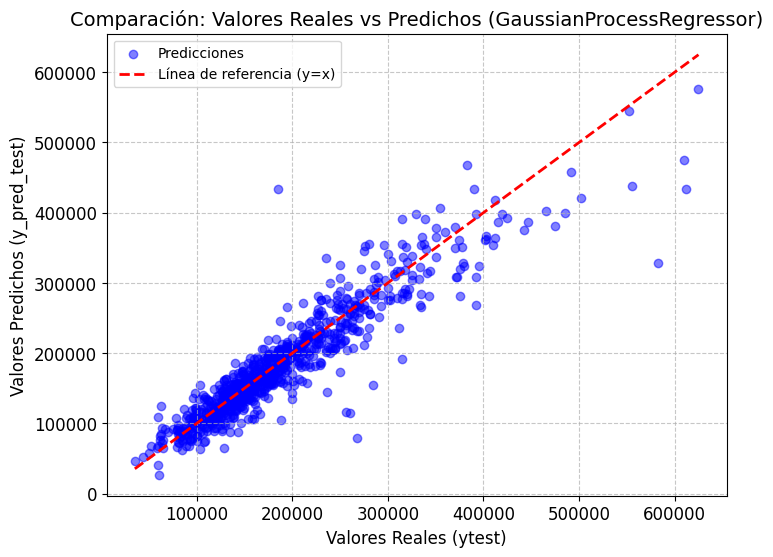

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform, uniform
import optuna
# Eliminar la importación de GPSampler si no es necesaria para GPR o si estás usando un muestreador estándar
# from optuna.samplers import GPSampler
import warnings
warnings.filterwarnings('ignore')

# Configuracion de validacion cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# --- Grid Search para GaussianProcessRegresor ---
# Reinicializar el pipeline para GaussianProcessRegressor
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', GaussianProcessRegressor(random_state=42)) # Agregar random_state para reproducibilidad
])

# Corregir nombres de parámetros para GridSearchCV
param_grid = {
    'regressor__alpha': np.logspace(-4, -1, 4),
    'regressor__normalize_y': [True, False],
    'regressor__copy_X_train': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(Xtrain_encoded, ytrain)

grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    # No es necesario set_params en el pipeline aquí, GridSearchCV lo maneja internamente durante el ajuste.
    # Podemos usar directamente el grid_search.best_estimator_ ajustado o recuperar resultados de cv_results_.
    # Sin embargo, para replicar la estructura original evaluando en Xtrain_encoded, lo ajustaremos aquí.
    # Nota: Este reajuste dentro del bucle es ineficiente y no es una práctica estándar después de GridSearchCV.
    # Un enfoque mejor sería usar cross_val_score con los mejores parámetros o reajustar grid_search.best_estimator_.
    # Por ahora, mantenemos la estructura similar al código original.
    current_pipeline = Pipeline([ # Crear una nueva instancia de pipeline para establecer parámetros específicos para la evaluación
        ('scaler', MinMaxScaler()),
        ('regressor', GaussianProcessRegressor(random_state=42))
    ])
    current_pipeline.set_params(**param)
    current_pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(current_pipeline, Xtrain_encoded, ytrain)
    grid_results.append({
        'alpha': param['regressor__alpha'],
        'normalize_y': param['regressor__normalize_y'],
        'copy_X_train': param['regressor__copy_X_train'],
        'MSE': -score, # MSE del score medio de validación cruzada
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Random Search para GaussianProcessRegresor ---
# La variable pipeline de GridSearchCV ya está inicializada correctamente.

# Corregir nombres de parámetros para RandomizedSearchCV
param_dist = {
    'regressor__alpha': loguniform(1e-4, 1e-1),
    'regressor__normalize_y': [True, False],
    'regressor__copy_X_train': [True, False]
}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=cv,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con múltiples métricas
random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    # Re-crear pipeline para la evaluación como en el bucle de GridSearchCV
    current_pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', GaussianProcessRegressor(random_state=42))
    ])
    current_pipeline.set_params(**param)
    current_pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(current_pipeline, Xtrain_encoded, ytrain)
    random_results.append({
        'alpha': param['regressor__alpha'],
        'normalize_y': param['regressor__normalize_y'],
        'copy_X_train': param['regressor__copy_X_train'],
        'MSE': -score, # MSE del score medio de validación cruzada
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Bayesian Optimization para GaussianProcessRegresor ---
bayes_results = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    normalize_y = trial.suggest_categorical('normalize_y', [True, False])
    copy_X_train = trial.suggest_categorical('copy_X_train', [True, False])
    # Re-crear pipeline dentro de la función objetivo
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', GaussianProcessRegressor(alpha=alpha, normalize_y=normalize_y,
                                               copy_X_train=copy_X_train, random_state=42)) # Agregar random_state
    ])
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)

    bayes_results.append({
        'trial': trial.number,
        'alpha': alpha,
        'normalize_y': normalize_y,
        'copy_X_train': copy_X_train,
        'MSE': metrics['MSE'], # MSE de los datos de entrenamiento *después* del ajuste del trial de optimización
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })
    # Optuna minimiza el valor de retorno, así que retornamos el MSE de la función evaluate_model
    # Nota: El MSE calculado aquí es sobre el conjunto de entrenamiento completo *después* del ajuste del trial,
    # lo cual es diferente de los scores de validación cruzada usados en Grid/Random Search.
    # Para consistencia, podrías querer usar cross_val_score aquí también, pero sería más lento.
    # Retornar el MSE de la función de evaluación se alinea con la minimización de la pérdida.
    return metrics['MSE']

# Asegurarse de que el muestreador de Optuna sea compatible o eliminar si no es estrictamente necesario/configurado
# Usar TPESampler por defecto suele estar bien para pruebas iniciales si GPSampler tiene problemas
# study = optuna.create_study(direction='minimize', sampler=GPSampler())
study = optuna.create_study(direction='minimize') # Usar TPESampler por defecto
study.optimize(objective, n_trials=20)

# ---Resultados del Grid Seacrh ---
best_grid_index = np.argmin([res['MSE'] for res in grid_results])
best_grid = grid_results[best_grid_index]
print("\nBest Grid Search Result:")
print(f"    alpha    = {best_grid['alpha']:.6f}")
print(f"    normalize_y    = {best_grid['normalize_y']}")
print(f"    copy_X_train    = {best_grid['copy_X_train']}")
print(f"    MSE    = {best_grid['MSE']:.6f}")
print(f"    MAE    = {best_grid['MAE']:.6f}")
print(f"    MAPE    = {best_grid['MAPE']:.6f}")
print(f"    R2    = {best_grid['R2']:.6f}")

# --- Resultados del Random Search ---
best_random_index = np.argmin([res['MSE'] for res in random_results])
best_random = random_results[best_random_index]
print("\nBest Random Search Result:")
print(f"    alpha    = {best_random['alpha']:.6f}")
print(f"    normalize_y    = {best_random['normalize_y']}")
print(f"    copy_X_train    = {best_random['copy_X_train']}")
print(f"    MSE    = {best_random['MSE']:.6f}")
print(f"    MAE    = {best_random['MAE']:.6f}")
print(f"    MAPE    = {best_random['MAPE']:.6f}")
print(f"    R2    = {best_random['R2']:.6f}")

# --- Resultados de Bayesian Optimization ---
best_bayes_index = np.argmin([res['MSE'] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]
print("\nBest Bayesian Optimization Result:")
print(f"    alpha    = {best_bayes['alpha']:.6f}")
print(f"    normalize_y    = {best_bayes['normalize_y']}")
print(f"    copy_X_train    = {best_bayes['copy_X_train']}")
print(f"    MSE    = {best_bayes['MSE']:.6f}")
print(f"    MAE    = {best_bayes['MAE']:.6f}")
print(f"    MAPE    = {best_bayes['MAPE']:.6f}")
print(f"    R2        = {best_bayes['R2']:.6f}")


# --- Evaluación en el conjunto de prueba con el mejor modelo ---
# Construir el pipeline final con los mejores parámetros de Bayesian Optimization
best_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', GaussianProcessRegressor(alpha=best_bayes['alpha'],
                                           normalize_y=best_bayes['normalize_y'],
                                           copy_X_train=best_bayes['copy_X_train'],
                                           random_state=42))
])
best_model.fit(Xtrain_encoded, ytrain)
y_pred_test = best_model.predict(Xtest_encoded)
test_metrics = evaluate_model(best_model, Xtest_encoded, ytest)

print("\nPerformance on Test Set with Best Model:")
print(f"    MSE    = {test_metrics['MSE']:.6f}")
print(f"    MAE    = {test_metrics['MAE']:.6f}")
print(f"    MAPE    = {test_metrics['MAPE']:.6f}")
print(f"    R2    = {test_metrics['R2']:.6f}")

# --- Gráfico de dispersión ytest vs y_pred_test ---
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred_test, alpha=0.5, color='blue', label='Predicciones')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         '--r', linewidth=2, label='Línea de referencia (y=x)')
plt.xlabel('Valores Reales (ytest)', fontsize=12)
plt.ylabel('Valores Predichos (y_pred_test)', fontsize=12)
plt.title('Comparación: Valores Reales vs Predichos (GaussianProcessRegressor)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#8. Estimador RandoForestRegressor

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[I 2025-05-24 10:07:28,664] A new study created in memory with name: no-name-7e98a865-faa1-4259-a78c-84943bc00acd
[I 2025-05-24 10:07:29,414] Trial 0 finished with value: 838253893.5471355 and parameters: {'n_estimators': 270, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 838253893.5471355.
[I 2025-05-24 10:07:33,749] Trial 1 finished with value: 464653762.93920505 and parameters: {'n_estimators': 281, 'max_depth': 40, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 464653762.93920505.
[I 2025-05-24 10:07:34,417] Trial 2 finished with value: 552574269.8593359 and parameters: {'n_estimators': 169, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 464653762.93920505.
[I 2025-05-24 10:07:35,069] Trial 3 finished with value: 596002390.3625638 and parameters: {'n_estimators': 203, 'max_depth': 35, 'min_sa


=== Resultados Detallados ===

--- Mejor Resultado Grid Search ---
  n_estimators: 200
  max_depth: 20
  min_samples_split: 2
  min_samples_leaf: 1
  MSE   = 732109692.863786
  MAE   = 5889.144229
  MAPE  = 0.036474
  R2    = 0.984755

--- Mejor Resultado Random Search ---
  n_estimators: 139
  max_depth: 15
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: sqrt
  MSE   = 710143610.019652
  MAE   = 10291.921995
  MAPE  = 0.064964
  R2    = 0.951856

--- Mejor Resultado Bayesian Optimization ---
  n_estimators: 219
  max_depth: 25
  min_samples_split: 4
  min_samples_leaf: 2
  max_features: None
  MSE   = 133328179.424525
  MAE   = 6623.173804
  MAPE  = 0.041329
  R2    = 0.978092

=== Rendimiento en Test (Bayesian Optimization) ===
  MSE   = 604741424.760820
  MAE   = 14855.350517
  MAPE  = 0.084767
  R2    = 0.913970


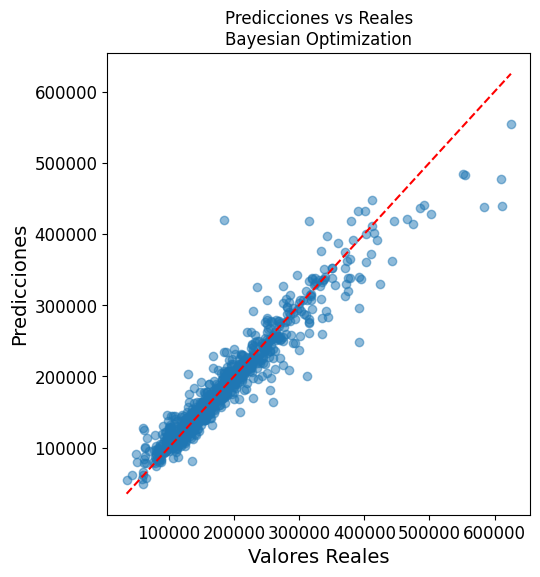

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

# Configuración de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Función para evaluar múltiples métricas
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# Pipeline base (aunque RandomForest no necesita escalado)
base_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Mantenemos por consistencia
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

## 1. Grid Search para Random Forest
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    base_pipe,
    param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados Grid Search
grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    pipe = base_pipe.set_params(**param)
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)
    grid_results.append({
        'params': param,
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

## 2. Random Search para Random Forest
param_dist = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': [None] + list(range(5, 50, 5)),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    base_pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados Random Search
random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    pipe = base_pipe.set_params(**param)
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)
    random_results.append({
        'params': param,
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

## 3. Bayesian Optimization para Random Forest
bayes_results = []

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    model.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(model, Xtrain_encoded, ytrain)

    bayes_results.append({
        'trial': trial.number,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

    return metrics['MSE']

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(objective, n_trials=30)

# Resultados Bayesian Optimization
best_bayes_index = np.argmin([res['MSE'] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]

## Imprimir resultados detallados para cada método

print("\n=== Resultados Detallados ===")

# Grid Search
best_grid_index = np.argmin([res['MSE'] for res in grid_results])
best_grid = grid_results[best_grid_index]
print("\n--- Mejor Resultado Grid Search ---")
print(f"  n_estimators: {best_grid['params']['model__n_estimators']}")
print(f"  max_depth: {best_grid['params']['model__max_depth']}")
print(f"  min_samples_split: {best_grid['params']['model__min_samples_split']}")
print(f"  min_samples_leaf: {best_grid['params']['model__min_samples_leaf']}")
print(f"  MSE   = {best_grid['MSE']:.6f}")
print(f"  MAE   = {best_grid['MAE']:.6f}")
print(f"  MAPE  = {best_grid['MAPE']:.6f}")
print(f"  R2    = {best_grid['R2']:.6f}")

# Random Search
best_random_index = np.argmin([res['MSE'] for res in random_results])
best_random = random_results[best_random_index]
print("\n--- Mejor Resultado Random Search ---")
print(f"  n_estimators: {best_random['params']['model__n_estimators']}")
print(f"  max_depth: {best_random['params']['model__max_depth']}")
print(f"  min_samples_split: {best_random['params']['model__min_samples_split']}")
print(f"  min_samples_leaf: {best_random['params']['model__min_samples_leaf']}")
print(f"  max_features: {best_random['params']['model__max_features']}")
print(f"  MSE   = {best_random['MSE']:.6f}")
print(f"  MAE   = {best_random['MAE']:.6f}")
print(f"  MAPE  = {best_random['MAPE']:.6f}")
print(f"  R2    = {best_random['R2']:.6f}")

# Bayesian Optimization
print("\n--- Mejor Resultado Bayesian Optimization ---")
print(f"  n_estimators: {best_bayes['n_estimators']}")
print(f"  max_depth: {best_bayes['max_depth']}")
print(f"  min_samples_split: {best_bayes['min_samples_split']}")
print(f"  min_samples_leaf: {best_bayes['min_samples_leaf']}")
print(f"  max_features: {best_bayes['max_features']}")
print(f"  MSE   = {best_bayes['MSE']:.6f}")
print(f"  MAE   = {best_bayes['MAE']:.6f}")
print(f"  MAPE  = {best_bayes['MAPE']:.6f}")
print(f"  R2    = {best_bayes['R2']:.6f}")

# Preparar resultados con estructura uniforme
all_best = [
    ('Grid Search', {
        'params': best_grid['params'],
        'metrics': {k: best_grid[k] for k in ['MSE', 'MAE', 'MAPE', 'R2']}
    }),
    ('Random Search', {
        'params': best_random['params'],
        'metrics': {k: best_random[k] for k in ['MSE', 'MAE', 'MAPE', 'R2']}
    }),
    ('Bayesian Optimization', {
        'params': {
            'model__n_estimators': best_bayes['n_estimators'],
            'model__max_depth': best_bayes['max_depth'],
            'model__min_samples_split': best_bayes['min_samples_split'],
            'model__min_samples_leaf': best_bayes['min_samples_leaf'],
            'model__max_features': best_bayes['max_features']
        },
        'metrics': {k: best_bayes[k] for k in ['MSE', 'MAE', 'MAPE', 'R2']}
    })
]

# Seleccionar el mejor método según el MSE
best_method_name, best_method = min(all_best, key=lambda x: x[1]['metrics']['MSE'])

# Entrenar el modelo final con los mejores hiperparámetros
final_model = base_pipe.set_params(**best_method['params'])
final_model.fit(Xtrain_encoded, ytrain)

# Evaluación en el conjunto de prueba
test_metrics = evaluate_model(final_model, Xtest_encoded, ytest)

# Mostrar resultados
print(f"\n=== Rendimiento en Test ({best_method_name}) ===")
print(f"  MSE   = {test_metrics['MSE']:.6f}")
print(f"  MAE   = {test_metrics['MAE']:.6f}")
print(f"  MAPE  = {test_metrics['MAPE']:.6f}")
print(f"  R2    = {test_metrics['R2']:.6f}")

# Gráficos comparativos
plt.figure(figsize=(12, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
plt.scatter(ytest, final_model.predict(Xtest_encoded), alpha=0.5)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')
plt.title(f"Predicciones vs Reales\n{best_method_name}")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

In [64]:
from optuna.visualization import (plot_optimization_history,plot_param_importances, plot_parallel_coordinate,plot_contour)

In [65]:
plot_optimization_history(study)

In [66]:
plot_param_importances(study)

#9. Estimador por Support Vector Machines Regresor

[I 2025-05-24 10:11:40,807] A new study created in memory with name: no-name-f95e4373-65be-418c-808a-a8ee342deeba
[I 2025-05-24 10:11:41,565] Trial 0 finished with value: 6430450363.968912 and parameters: {'kernel': 'sigmoid', 'C': 2.078015686307004, 'gamma': 'auto'}. Best is trial 0 with value: 6430450363.968912.
[I 2025-05-24 10:11:41,984] Trial 1 finished with value: 5146640146.638619 and parameters: {'kernel': 'linear', 'C': 14.766018445631365, 'gamma': 'scale'}. Best is trial 1 with value: 5146640146.638619.
[I 2025-05-24 10:11:42,414] Trial 2 finished with value: 6337366976.645096 and parameters: {'kernel': 'linear', 'C': 1.0324642027179751, 'gamma': 'auto'}. Best is trial 1 with value: 5146640146.638619.
[I 2025-05-24 10:11:43,149] Trial 3 finished with value: 6423588972.598231 and parameters: {'kernel': 'sigmoid', 'C': 7.138060373068457, 'gamma': 'auto'}. Best is trial 1 with value: 5146640146.638619.
[I 2025-05-24 10:11:43,585] Trial 4 finished with value: 6423028979.946952 an


Best Grid Search Result:
    kernel    = poly
    C    = 100
    gamma    = scale
    MSE    = 1510940992.788858
    MAE    = 21939.478274
    MAPE    = 0.125912
    R2    = 0.773074

Best Random Search Result:
    kernel    = poly
    C    = 100
    gamma    = scale
    MSE    = 1510940992.788858
    MAE    = 21939.478274
    MAPE    = 0.125912
    R2    = 0.773074

Best Bayesian Optimization Result:
    kernel    = poly
    C    = 29.170014893000072
    gamma    = scale
    MSE    = 2420104883.589097
    MAE    = 29800.753399
    MAPE    = 0.168209
    R2    = 0.602334

=== Rendimiento en Test ===
    MSE    = 1453280165.217023
    MAE    = 23086.574866
    MAPE    = 0.122035
    R2    = 0.793258


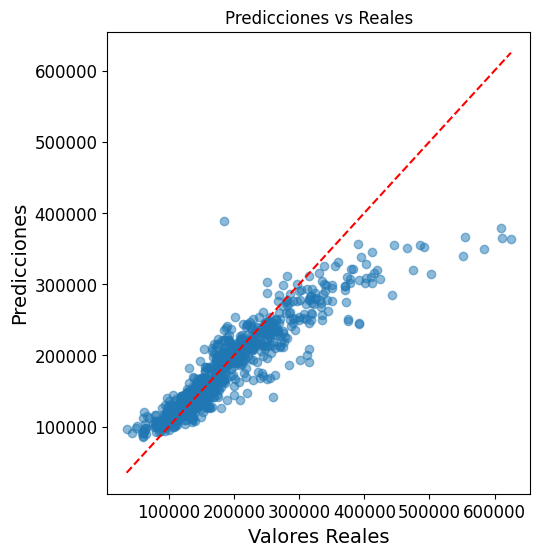

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform, uniform
import optuna
import warnings
warnings.filterwarnings('ignore')

# Configuración de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Función para evaluar múltiples métricas
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mean_squared_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'R2': r2_score(y, y_pred)
    }

# --- Grid Search para svm ---
param_grid = {
    'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': ['scale', 'auto']
}
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', svm.SVR())
])
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con múltiples métricas
grid_results = []
for param, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    pipeline.set_params(**param)
    pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipeline, Xtrain_encoded, ytrain)
    grid_results.append({
        'kernel': param['regressor__kernel'],
        'C': param['regressor__C'],
        'gamma': param['regressor__gamma'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# --- Random Search para svm ---
param_dist = {
    'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': ['scale', 'auto']
}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=cv,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search.fit(Xtrain_encoded, ytrain)

# Almacenar resultados con multiples metricas
random_results = []
for param, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']):
    pipeline.set_params(**param)
    pipeline.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipeline, Xtrain_encoded, ytrain)
    random_results.append({
        'kernel': param['regressor__kernel'],
        'C': param['regressor__C'],
        'gamma': param['regressor__gamma'],
        'MSE': -score,
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })

# ---Bayesian Optimization para svm ---
bayes_results = []

def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_float('C', 0.1, 100, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', svm.SVR(kernel=kernel, C=C, gamma=gamma))
    ])
    pipe.fit(Xtrain_encoded, ytrain)
    metrics = evaluate_model(pipe, Xtrain_encoded, ytrain)
    bayes_results.append({
        'trial': trial.number,
        'kernel': kernel,
        'C': C,
        'gamma': gamma,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2']
    })
    return metrics['MSE']

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# ---Resultados del Grid Seacrh ---
best_grid_index = np.argmin([res['MSE'] for res in grid_results])
best_grid = grid_results[best_grid_index]
print("\nBest Grid Search Result:")
print(f"    kernel    = {best_grid['kernel']}")
print(f"    C    = {best_grid['C']}")
print(f"    gamma    = {best_grid['gamma']}")
print(f"    MSE    = {best_grid['MSE']:.6f}")
print(f"    MAE    = {best_grid['MAE']:.6f}")
print(f"    MAPE    = {best_grid['MAPE']:.6f}")
print(f"    R2    = {best_grid['R2']:.6f}")

# --- Resultados del Random Search ---
best_random_index = np.argmin([res['MSE'] for res in random_results])
best_random = random_results[best_random_index]
print("\nBest Random Search Result:")
print(f"    kernel    = {best_random['kernel']}")
print(f"    C    = {best_random['C']}")
print(f"    gamma    = {best_random['gamma']}")
print(f"    MSE    = {best_random['MSE']:.6f}")
print(f"    MAE    = {best_random['MAE']:.6f}")
print(f"    MAPE    = {best_random['MAPE']:.6f}")
print(f"    R2    = {best_random['R2']:.6f}")

# --- Resultados de Bayesian Optimization ---
best_bayes_index = np.argmin([res['MSE'] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]
print("\nBest Bayesian Optimization Result:")
print(f"    kernel    = {best_bayes['kernel']}")
print(f"    C    = {best_bayes['C']}")
print(f"    gamma    = {best_bayes['gamma']}")
print(f"    MSE    = {best_bayes['MSE']:.6f}")
print(f"    MAE    = {best_bayes['MAE']:.6f}")
print(f"    MAPE    = {best_bayes['MAPE']:.6f}")
print(f"    R2    = {best_bayes['R2']:.6f}")

# --- Evaluación en el conjunto de prueba con el mejor modelo ---
best_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', svm.SVR(kernel=best_grid['kernel'], C=best_grid['C'], gamma=best_grid['gamma']))
])
best_model.fit(Xtrain_encoded, ytrain)
y_pred_test = best_model.predict(Xtest_encoded)
test_metrics = evaluate_model(best_model, Xtest_encoded, ytest)

print("\n=== Rendimiento en Test ===")
print(f"    MSE    = {test_metrics['MSE']:.6f}")
print(f"    MAE    = {test_metrics['MAE']:.6f}")
print(f"    MAPE    = {test_metrics['MAPE']:.6f}")
print(f"    R2    = {test_metrics['R2']:.6f}")

# --- Gráfico de dispersión ytest vs y_pred_test ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(ytest, y_pred_test, alpha=0.5)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')
plt.title("Predicciones vs Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

In [68]:
plot_optimization_history(study)

In [69]:
plot_param_importances(study)